In [ ]:
#@title Google Colab Workbook for feature extraction and classifier train/test for the manuscript: *Learned Features of Antibody-Antigen Binding Affinity*

#@markdown Instructions:  \

#@markdown 1) Connect to a runtime  \
#@markdown - CPU runtime if not computing all features from scratch. Approximate run-time of 10 minutes. Note that this is the default setting \
#@markdown - GPU or TPU runtime is required for re-calculating all features. Approximate run-time of ~3 hours. Note that PDB relaxation, SIN, and dMaSIF are not directly implemented in this workbook. \

#@markdown 2) Select options for dataset curation and classifier parameters in the final cell (e.g., which feature-sets and classifier archiecture to use)

#@markdown 3) Select "Run all" under the "Runtime" drop-down menu, or alternatively run each cell manually one-by-one to explore the implementation

#@markdown Note: Code in this notebook was refactored by ChatGPT

In [ ]:
#@title Install dependencies, clone protein_interactions Git, and load all pre-processed PDB files
#@markdown Github: https://github.com/nkmiller/protein_interactions \

#@markdown This cell takes ~3 minutes to run  
!pip install biopandas &> /dev/null
!pip install biopython &> /dev/null
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs
!git lfs install
!git clone https://github.com/nkmiller/protein_interactions.git
import pandas as pd
import numpy as np
!unzip /content/protein_interactions/Antibody_DB/sabdab/chothia_opt_relaxed.zip 
!unzip /content/protein_interactions/Antibody_DB/sin.zip &> /dev/null
import sys
sys.path.append('/content/protein_interactions/')
from SequenceUtilities import seqID, getNumbering

#@title Load MetaData
import json
def loadSoft(_x):
  try:
    return json.loads(_x)
  except:
    return _x
df = pd.read_csv('/content/protein_interactions/Antibody_DB/sabdab/sabdab_summary.csv')
df['vh_numbered'] = df['vh_numbered'].apply(loadSoft)
df['vl_numbered'] = df['vl_numbered'].apply(loadSoft)

df_TC = df
df_TC = df_TC.drop(['affinity', 'affinity_method'], axis=1)

df_affinity = pd.read_csv('/content/protein_interactions/Antibody_DB/20220918_0660132/20220918_0660132_summary.tsv', sep='\t')
df_affinity.rename(columns={"pdb": "pdb_id"}, inplace=True)
df_affinity_clean = pd.DataFrame()
df_affinity_clean['pdb_id'] = df_affinity['pdb_id'].apply(loadSoft)
df_affinity_clean['affinity'] = df_affinity['affinity'].apply(loadSoft)
df_affinity_clean['affinity_method'] = df_affinity['affinity_method'].apply(loadSoft)
df_affinity_clean = df_affinity_clean.drop_duplicates()

df_merged = pd.merge(df_affinity_clean, df_TC, how='inner', on=['pdb_id'])
df_merged = df_merged.drop_duplicates(subset=['pdb_id'], keep=False) 
del df, df_TC, df_affinity, df_affinity_clean
df = df_merged

def remove_homologous_Abs(df):
  duplicate_to_del = []
  for i, row_i in df.iterrows():
    if row_i['l3_length'] <= 0:
      continue
    max_h = 0
    for j, row_j in df.iterrows():
      if i == j:
        continue
      hid = seqID(row_i['vh_numbered'], row_j['vh_numbered'], getNumbering('H'))
      if hid > max_h:
        max_h = hid
        max_j = row_j
    if max_h > 0.95:
      aff_i = -np.log10(row_i['affinity'])
      aff_j = -np.log10(max_j['affinity'])
      if (row_i['pdb_id'] not in duplicate_to_del) and (max_j['pdb_id'] not in duplicate_to_del):
        if abs(aff_i - 9) > abs(aff_j - 9):
          duplicate_to_del.append(max_j['pdb_id'])
        else:
          duplicate_to_del.append(row_i['pdb_id'])
  return duplicate_to_del

all_duplicates = []
i = 1
while True:
  duplicate_to_del = remove_homologous_Abs(df)
  if not duplicate_to_del:
    break
  print(duplicate_to_del)
  print(f'Removing high homology antibodies: round {i}')
  all_duplicates.append(duplicate_to_del)
  df = df[~df['pdb_id'].isin(duplicate_to_del)]
  i += 1

duplicate_to_del = sum(all_duplicates, []) # flatten
df = df_merged # reset df, just keep del indices

Detected operating system as Ubuntu/focal.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Detected apt version as 2.0.9
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... Packagecloud gpg key imported to /etc/apt/keyrings/github_git-lfs-archive-keyring.gpg
done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
The following packages will be upgraded:
  git-lfs
1 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.
Need to get 7,419 kB of archives.
After this operation, 4,936 kB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubun

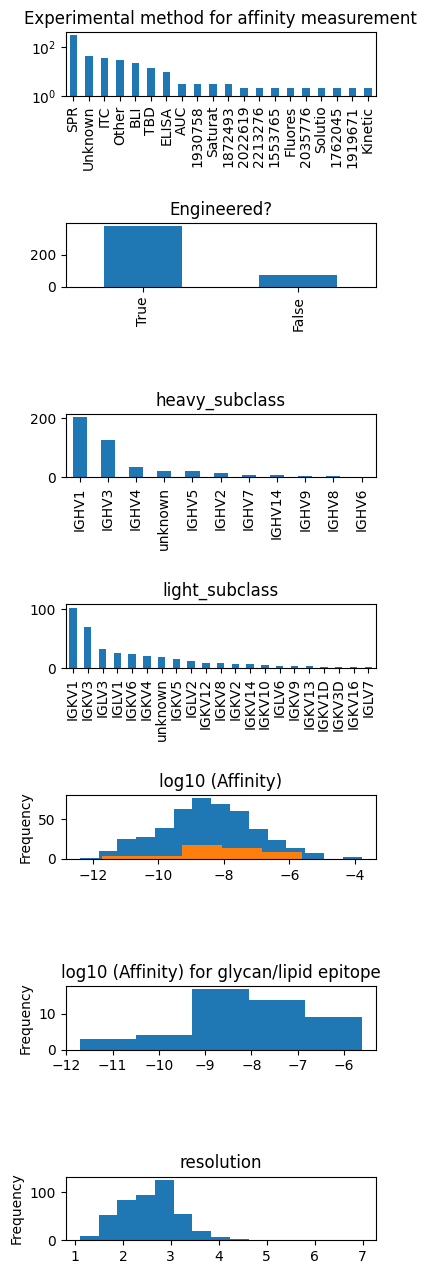

In [ ]:
#@title Plot initial summary statistics for dataset
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


non_PPI = ['4k9e','4aei','5hys','5te4','4jzj','5c6t','3ngb','2aeq','1nma','4hlz','3g6d','1qfw','1fe8','4jkp','2ny7','6bck','6mft','5u7m','4r2g','4f9l','6a67','3rvw','4fqj','5czx','5cd5','5igx','5kvd','6bkc','4dtg','3idy','5vob','3ubx','4hwb','4dkf','3q1s','3sdy','4f37','3lev','4gms','5u8q','5lcv','5xwd','5anm','6a0z','6bf4','5j3h','4j4p']
df_merged_nonPPI = df_merged[df_merged['pdb_id'].isin(non_PPI)]

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(4, 16), dpi=100, sharex=False, sharey=False)
plt.subplots_adjust(hspace=2)
ax1 = plt.subplot(711)
ax1.set_title('Experimental method for affinity measurement')
df_merged['affinity_method'].apply(lambda x: str(x)[:7]).value_counts().plot(kind='bar', ax=ax1, log=True)

ax2 = plt.subplot(712)
ax2.set_title('Engineered?')
df_merged['engineered'].value_counts().plot(kind='bar', ax=ax2)

ax3 = plt.subplot(713)
ax3.set_title('heavy_subclass')
df_merged['heavy_subclass'].value_counts().plot(kind='bar', ax=ax3)

ax4 = plt.subplot(714)
ax4.set_title('light_subclass')
df_merged['light_subclass'].value_counts().plot(kind='bar', ax=ax4)

ax5 = plt.subplot(715)
ax5.set_title('log10 (Affinity)')
np.log10(df_merged['affinity']).plot(kind='hist', bins=15, ax=ax5)
np.log10(df_merged_nonPPI['affinity']).plot(kind='hist', bins=5, ax=ax5)

ax6 = plt.subplot(716)
ax6.set_title('log10 (Affinity) for glycan/lipid epitope')
np.log10(df_merged_nonPPI['affinity']).plot(kind='hist', bins=5, ax=ax6)

ax7 = plt.subplot(717)
ax7.set_title('resolution')
df_merged['resolution'].plot(kind='hist', bins=15, ax=ax7)


In [ ]:
#@title Classify Residue Interface Properties, Generate Backbone Distances Matrix, and AA Side Chain Length Calculation

#@markdown This cell takes ~2min to run if not re-calculating these data, and ~15 min to run for a full recalculation 

RECALCULATE_SASA_CLASSES = False #@param {type:"boolean"}
RECALCULATE_AA_SC = False #@param {type:"boolean"}

import torch

if RECALCULATE_SASA_CLASSES:
  from biopandas.pdb import PandasPdb
  !pip install freesasa
  import freesasa

  def getAntigenChains(_row):
    toret = []
    for i in range(1,4):
      if type(_row['antigen_chain_{}'.format(i)]) is str:
        toret+=[_row['antigen_chain_{}'.format(i)]]
    return ','.join(toret)

  def getParatopeChains(_row):
    toret = ['H']
    if type(_row['lchain']) is str:
      toret+=['L']
    return ','.join(toret)


  def separateComplex(pdb_path,ab_chains,antigen_chains):
    if not(ab_chains=='H,L' or ab_chains=='L,H'):
      raise
    antigen_chains = antigen_chains.split(',')
    ppdb = PandasPdb().read_pdb(pdb_path)
    atom_df = ppdb.df['ATOM'].copy(deep=True)
    hetatm_df = ppdb.df['HETATM'].copy(deep=True)

    ppdb_ab = PandasPdb()
    ppdb_ab.df['ATOM'] = atom_df[atom_df.chain_id.isin(['H','L'])].reset_index().drop('index',axis=1)
    ppdb_ab.df['HETATM'] = pd.DataFrame(columns=hetatm_df.columns)

    ppdb_ag = PandasPdb()
    ppdb_ag.df['ATOM'] = atom_df[atom_df.chain_id.isin(antigen_chains)].reset_index().drop('index',axis=1)
    ppdb_ag.df['HETATM'] = pd.DataFrame(columns=hetatm_df.columns)

    ppdb_ab.to_pdb(records=['ATOM','HETATM'], 
                  gz=False, 
                  append_newline=True,
                  path=pdb_path.split('.pdb')[0]+'_ab.pdb')
    ppdb_ag.to_pdb(records=['ATOM','HETATM'], 
                  gz=False, 
                  append_newline=True,
                  path=pdb_path.split('.pdb')[0]+'_ag.pdb')

  def classifyPoint(rasam,rasac,drasa_thresh=.1):
    #**Interior**:	rASAc<.25	drASA=0 0 
    #**Surface**:	  rASAc>.25	drASA=0 1
    #**Support**:	  rASAm<.25	drASA=0 2
    #**Rim**:		rASAc>.25	drASA>0 3
    #**Core**:	rASAm>.25	rASAc<.25	drASA>0 4
    toret = -1
    drasa = rasam-rasac
    if drasa<drasa_thresh:
      if rasac<.25:
        toret = 0
      elif rasac>=.25:
        toret = 1
    else:
      if rasam<.25:
        toret = 2
      elif rasac>.25:
        toret=3
      else: #rasam>=.25, rasac<=.25
        toret = 4
    
    return toret


  def getInterfaceClasses(pdb_path,antibody_chains,antigen_chains):
    separateComplex(pdb_path,antibody_chains,antigen_chains)
    comp = freesasa.Structure(pdb_path)
    comp = freesasa.calc(comp)

    ab   = freesasa.Structure(pdb_path.split('.pdb')[0]+'_ab.pdb')
    ab   = freesasa.calc(ab)

    ag   = freesasa.Structure(pdb_path.split('.pdb')[0]+'_ag.pdb')
    ag   = freesasa.calc(ag)
    sasa_class = {}
    for c in ab.residueAreas():
      sasa_class[c] = {}
      for r in ab.residueAreas()[c]:
        rasam = ab.residueAreas()[c][r].relativeTotal
        rasac = comp.residueAreas()[c][r].relativeTotal
        sasa_class[c][r] = classifyPoint(rasam,rasac)
    for c in ag.residueAreas():
      sasa_class[c] = {}
      for r in ag.residueAreas()[c]:
        rasam = ag.residueAreas()[c][r].relativeTotal
        rasac = comp.residueAreas()[c][r].relativeTotal
        sasa_class[c][r] = classifyPoint(rasam,rasac)

    return sasa_class

  import time
  sasa_classes = {}
  t = time.time()
  fails = []
  for i in df.index:

    try:
      pdb_path = './chothia_opt_relaxed/{}_clean_opt_0.pdb'.format(df.loc[i,'pdb_id'])
      antibody_chains = getParatopeChains(df.loc[i])
      antigen_chains = getAntigenChains(df.loc[i])
      sasa_classes[df.loc[i,'pdb_id']] = getInterfaceClasses(pdb_path,antibody_chains,antigen_chains)
    except:
      print('FAILED: {}'.format(i))
      fails+=[i]

  torch.save(sasa_classes, '/content/protein_interactions/Antibody_DB/residue_interface_classes.pt')
else:
  sasa_classes = torch.load('/content/protein_interactions/Antibody_DB/residue_interface_classes.pt')


# BB Distances Matrix
import torch
import warnings
from Bio import BiopythonWarning
from Bio.PDB import Selection
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.Polypeptide import three_to_one, three_to_index, is_aa

NON_STANDARD_SUBSTITUTIONS = {
    '2AS':'ASP', '3AH':'HIS', '5HP':'GLU', 'ACL':'ARG', 'AGM':'ARG', 'AIB':'ALA', 'ALM':'ALA', 'ALO':'THR', 'ALY':'LYS', 'ARM':'ARG',
    'ASA':'ASP', 'ASB':'ASP', 'ASK':'ASP', 'ASL':'ASP', 'ASQ':'ASP', 'AYA':'ALA', 'BCS':'CYS', 'BHD':'ASP', 'BMT':'THR', 'BNN':'ALA',
    'BUC':'CYS', 'BUG':'LEU', 'C5C':'CYS', 'C6C':'CYS', 'CAS':'CYS', 'CCS':'CYS', 'CEA':'CYS', 'CGU':'GLU', 'CHG':'ALA', 'CLE':'LEU', 'CME':'CYS',
    'CSD':'ALA', 'CSO':'CYS', 'CSP':'CYS', 'CSS':'CYS', 'CSW':'CYS', 'CSX':'CYS', 'CXM':'MET', 'CY1':'CYS', 'CY3':'CYS', 'CYG':'CYS',
    'CYM':'CYS', 'CYQ':'CYS', 'DAH':'PHE', 'DAL':'ALA', 'DAR':'ARG', 'DAS':'ASP', 'DCY':'CYS', 'DGL':'GLU', 'DGN':'GLN', 'DHA':'ALA',
    'DHI':'HIS', 'DIL':'ILE', 'DIV':'VAL', 'DLE':'LEU', 'DLY':'LYS', 'DNP':'ALA', 'DPN':'PHE', 'DPR':'PRO', 'DSN':'SER', 'DSP':'ASP',
    'DTH':'THR', 'DTR':'TRP', 'DTY':'TYR', 'DVA':'VAL', 'EFC':'CYS', 'FLA':'ALA', 'FME':'MET', 'GGL':'GLU', 'GL3':'GLY', 'GLZ':'GLY',
    'GMA':'GLU', 'GSC':'GLY', 'HAC':'ALA', 'HAR':'ARG', 'HIC':'HIS', 'HIP':'HIS', 'HMR':'ARG', 'HPQ':'PHE', 'HTR':'TRP', 'HYP':'PRO',
    'IAS':'ASP', 'IIL':'ILE', 'IYR':'TYR', 'KCX':'LYS', 'LLP':'LYS', 'LLY':'LYS', 'LTR':'TRP', 'LYM':'LYS', 'LYZ':'LYS', 'MAA':'ALA', 'MEN':'ASN',
    'MHS':'HIS', 'MIS':'SER', 'MLE':'LEU', 'MPQ':'GLY', 'MSA':'GLY', 'MSE':'MET', 'MVA':'VAL', 'NEM':'HIS', 'NEP':'HIS', 'NLE':'LEU',
    'NLN':'LEU', 'NLP':'LEU', 'NMC':'GLY', 'OAS':'SER', 'OCS':'CYS', 'OMT':'MET', 'PAQ':'TYR', 'PCA':'GLU', 'PEC':'CYS', 'PHI':'PHE',
    'PHL':'PHE', 'PR3':'CYS', 'PRR':'ALA', 'PTR':'TYR', 'PYX':'CYS', 'SAC':'SER', 'SAR':'GLY', 'SCH':'CYS', 'SCS':'CYS', 'SCY':'CYS',
    'SEL':'SER', 'SEP':'SER', 'SET':'SER', 'SHC':'CYS', 'SHR':'LYS', 'SMC':'CYS', 'SOC':'CYS', 'STY':'TYR', 'SVA':'SER', 'TIH':'ALA',
    'TPL':'TRP', 'TPO':'THR', 'TPQ':'ALA', 'TRG':'LYS', 'TRO':'TRP', 'TYB':'TYR', 'TYI':'TYR', 'TYQ':'TYR', 'TYS':'TYR', 'TYY':'TYR'
}


RESIDUE_SIDECHAIN_POSTFIXES = {
    'A': ['CB'],
    'R': ['CB', 'CG', 'CD', 'NE', 'CZ', 'NH1', 'NH2'],
    'N': ['CB', 'CG', 'OD1', 'ND2'],
    'D': ['CB', 'CG', 'OD1', 'OD2'],
    'C': ['CB', 'SG'],
    'E': ['CB', 'CG', 'CD', 'OE1', 'OE2'],
    'Q': ['CB', 'CG', 'CD', 'OE1', 'NE2'],
    'G': [],
    'H': ['CB', 'CG', 'ND1', 'CD2', 'CE1', 'NE2'],
    'I': ['CB', 'CG1', 'CG2', 'CD1'],
    'L': ['CB', 'CG', 'CD1', 'CD2'],
    'K': ['CB', 'CG', 'CD', 'CE', 'NZ'],
    'M': ['CB', 'CG', 'SD', 'CE'],
    'F': ['CB', 'CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ'],
    'P': ['CB', 'CG', 'CD'],
    'S': ['CB', 'OG'],
    'T': ['CB', 'OG1', 'CG2'],
    'W': ['CB', 'CG', 'CD1', 'CD2', 'NE1', 'CE2', 'CE3', 'CZ2', 'CZ3', 'CH2'],
    'Y': ['CB', 'CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ', 'OH'],    
    'V': ['CB', 'CG1', 'CG2'],
}

GLY_INDEX = 5
ATOM_N, ATOM_CA, ATOM_C, ATOM_O, ATOM_CB  = 0, 1, 2, 3, 4

CDRS = {'H1':(25,33),#(23,36),
        'H2':(50,58),#(50,58),
        'H3':(92,104),#(93,102),
        'L1':(25,33),#(24,34),
        'L2':(49,53),#(49,56),
        'L3':(90,97)}#(89,97)}

def i2res(i,data):
    return data['chain_id'][i]+str(data['resseq'][i].numpy())+data['icode'][i].strip()

def augmented_three_to_one(three):
    if three in NON_STANDARD_SUBSTITUTIONS:
        three = NON_STANDARD_SUBSTITUTIONS[three]
    return three_to_one(three)


def augmented_three_to_index(three):
    if three in NON_STANDARD_SUBSTITUTIONS:
        three = NON_STANDARD_SUBSTITUTIONS[three]
    return three_to_index(three)


def augmented_is_aa(three):
    if three in NON_STANDARD_SUBSTITUTIONS:
        three = NON_STANDARD_SUBSTITUTIONS[three]
    return is_aa(three, standard=True)


def is_hetero_residue(res):
    return len(res.id[0].strip()) > 0


def get_atom_name_postfix(atom):
    name = atom.get_name()
    return name

def get_virtual_cb(pos5):
    #pos
    b = pos5[:,ATOM_CA,:] - pos5[:,ATOM_N]
    c = pos5[:,ATOM_C,:]  - pos5[:,ATOM_CA]
    a = torch.linalg.cross(b,c)
    return -0.58273431*a + 0.56802827*b - 0.54067466*c +pos5[:,ATOM_CA,:]

def get_residue_pos14(res):
    pos14 = torch.full([14, 3], float('inf'))
    suffix_to_atom = {get_atom_name_postfix(a):a for a in res.get_atoms()}
    atom_order = ['N', 'CA', 'C', 'O'] + RESIDUE_SIDECHAIN_POSTFIXES[augmented_three_to_one(res.get_resname())]
    
    d = {}
    for i, atom_suffix in enumerate(atom_order):
        if atom_suffix not in suffix_to_atom: continue
        pos14[i,0], pos14[i,1], pos14[i,2] = suffix_to_atom[atom_suffix].get_coord().tolist()
    return pos14

def numstr2tup(_n):
    import re
    match = re.match(r"([0-9]+)([a-z]+)", _n, re.I)
    if match:
        items = match.groups()
        return (int(items[0]),items[1])
    else:
        return (int(_n),' ')

def addSin(data):
  sin = pd.read_csv('./sin/{}_clean_opt_sin.csv'.format(data['name']),header = None,dtype={1:str})
  sin_norm = np.nan
  with open('./sin/{}_clean_opt_norm.txt'.format(data['name']),'r') as f:
    sin_norm = float(f.read())

  chain_id = sin[0].values
  resn = sin[1].values
  resi = []
  icode = []
  for r in resn:
    ri, ic = numstr2tup(r)
    resi+=[ri]
    icode+=[ic]

  resi = np.array(resi)
  icode = np.array(icode)

  if (np.all(np.array(list(data['chain_id']))==chain_id) and \
      np.all(data['resseq'].numpy()==resi) and \
      np.all(np.array(list(data['icode']))==icode))==False:
    raise

  data['sin'] = torch.Tensor(sin.loc[0:,3:].values)
  data['sin_norm'] = sin_norm
  return data


def parse_pdb(path,pdb_id,return_pos14=False,model_id=0):
    warnings.simplefilter('ignore', BiopythonWarning)
    parser = PDBParser()
    structure = parser.get_structure(None, path)
    data = parse_complex(structure,pdb_id, return_pos14, model_id)
    data = addSin(data)
    return data


def get_paratope_mask(pos14,pos14_mask,antibody_mask,antigen_mask,cutoff=4.5):
    """returns the linear indices of
       paratope residues as 
       defined by heavy atom distance <=cutoff.  
       NOTE: ASSUMES THAT ANTIBODY CHAIN(S) ARE FIRST IN THE COMPLEX"""
    
    ab = pos14[antibody_mask==True,:,:].reshape((antibody_mask==True).sum()*14,3)
    ab_mask = pos14_mask[antibody_mask==True,:,:].reshape((antibody_mask==True).sum()*14,3).all(axis=1)
    
    res_ix = torch.tensor([i for i in range((antibody_mask==True).sum()) for x in range(14)])
    res_ix = res_ix[ab_mask]
    
    ag = pos14[antigen_mask==True,:,:].reshape((antigen_mask==True).sum()*14,3)
    ag_mask = pos14_mask[antigen_mask==True,:,:].reshape((antigen_mask==True).sum()*14,3).all(axis=1)
    paratope_mask = torch.LongTensor([False]*len(antibody_mask))
    paratope_mask[res_ix[torch.cdist(ab[ab_mask,:],ag[ag_mask,:]).min(axis=1).values<=cutoff].unique()] = True
    return paratope_mask
  
def parse_complex(structure, pdb_id,return_pos14=False,model_id=None):
    if model_id is not None:
        structure = structure[model_id]
    chains = Selection.unfold_entities(structure, 'C')

    aa, resseq, icode, seq, interface_class = [], [], [], [], []
    pos14, pos14_mask = [], []
    chain_id, chain_seq = [], []
    for i, chain in enumerate(chains):
        seq_this = 0
        for res in chain:
            resname = res.get_resname()
            if not augmented_is_aa(resname): continue
            if not (res.has_id('CA') and res.has_id('C') and res.has_id('N')): continue

            # Chain
            chain_id.append(chain.get_id())
            chain_seq.append(i+1)

            # Residue types
            restype = augmented_three_to_index(resname)
            aa.append(restype)

            # Atom coordinates
            #
            pos14_this = get_residue_pos14(res)
            pos14_mask_this = pos14_this.isfinite()
            pos14.append(pos14_this.nan_to_num(posinf=99999))
            pos14_mask.append(pos14_mask_this)
            
            # Sequential number
            resseq_this = int(res.get_id()[1])
            icode_this = res.get_id()[2]    

            #sasa
            interface_class+=[sasa_classes[pdb_id][chain.get_id()][str(resseq_this)+icode_this.strip()]]


            if seq_this == 0:
                seq_this = 1
            else:
                d_resseq = resseq_this - resseq[-1]
                if d_resseq == 0: seq_this += 1
                else: seq_this += d_resseq
            resseq.append(resseq_this)
            icode.append(icode_this)
            seq.append(seq_this)
    
    
    
    if len(aa) == 0:
        return None
    
    pos14 = torch.stack(pos14)
    pos14_mask = torch.stack(pos14_mask)
    
    antibody_mask = torch.LongTensor([x in ['H','L'] for x in list(chain_id)])
    
    if not antibody_mask[0]:
        raise ValueError('ANTIBODY CHAIN(S) NOT FIRST!')
        
    antigen_mask = torch.LongTensor([x not in ['H','L'] for x in list(chain_id)])
    paratope_mask = get_paratope_mask(pos14,pos14_mask,antibody_mask,antigen_mask,cutoff=4.5)
    
    ###GET POS5
    pos5 = torch.zeros((len(pos14),5,3))
    pos5.copy_(pos14[:,[ATOM_N,ATOM_CA,ATOM_C,ATOM_O,ATOM_CB],:])
    pos5[:,ATOM_CB,:] = get_virtual_cb(pos5)
    
    pos5_mask = pos14_mask[:,[ATOM_N,ATOM_CA,ATOM_C,ATOM_O,ATOM_CB],:]
    pos5_mask[:,ATOM_CB,:] = pos5[:,ATOM_CB,:]<99999
    residue_mask = pos5_mask.all(axis=-1).all(axis=-1).int()
    toret =  {
        'name': pdb_id,
        # Chain
        'chain_id': ''.join(chain_id),
        'chain_seq': torch.LongTensor(chain_seq),
        # Sequence
        'aa': torch.LongTensor(aa), 
        'resseq': torch.LongTensor(resseq), 
        'icode': ''.join(icode), 
        'seq': torch.LongTensor(seq),
        'antibody_mask': antibody_mask,
        'antigen_mask':  antigen_mask,
        'paratope_mask': paratope_mask,
        # Atom positions
        'pos5':pos5, 
        'pos5_mask': pos5_mask,
        'residue_mask':residue_mask,
        'interface_class':torch.LongTensor(interface_class)
    }
    chain_ids = np.array(list(toret['chain_id']))
    resseq = toret['resseq'].numpy()

    for CDR in CDRS:
      toret['{}_mask'.format(CDR)] = torch.LongTensor((chain_ids==CDR[0])&(resseq>=CDRS[CDR][0])&(resseq<=CDRS[CDR][1]))
    toret['ag_mask'] = torch.LongTensor(np.isin(chain_ids,['H','L'])==False)
    
    if return_pos14==1:
      del toret['pos5']
      del toret['pos5_mask']
      toret['pos14'] = pos14
      toret['pos14_mask'] = pos14_mask

    
    return toret



import time
t = time.time()

fails = []
for i in df.index:
  pdb_path_opt  = "./chothia_opt_relaxed/{}_clean_opt_0.pdb".format(df.loc[i,'pdb_id'])
  try:
    data = parse_pdb(pdb_path_opt,df.loc[i,'pdb_id'])
  except:
    print("FAILED: {}".format(df.index[i]))
    fails+=[i]
  D = torch.sqrt(torch.sum((torch.unsqueeze(data['pos5'],0)-torch.unsqueeze(data['pos5'],1))**2,3))
  D, _  = torch.min(D,-1)
  data['D'] = D
  torch.save(data,'./chothia_opt_relaxed/{}.pt'.format(df.loc[i,'pdb_id']))

torch.save(fails,'./chothia_opt_relaxed/fails.pt')


df = df.drop(fails).reset_index().drop('index',axis=1)
print(np.round((time.time()-t)/60,2))

import time
from Bio.PDB.Polypeptide import one_to_index

if RECALCULATE_AA_SC:
  t = time.time()
  fails = []
  aa_data = {}

  for i in df.index:
    pdb_path_opt  = "./chothia_opt_relaxed/{}_clean_opt_0.pdb".format(df.loc[i,'pdb_id'])
    try:
      data = parse_pdb(pdb_path_opt,df.loc[i,'pdb_id'],True)
      ALA_INDEX = 0 
      mask = (data['aa']!=GLY_INDEX)&data['residue_mask']&(data['aa']!=ALA_INDEX)
      D = data['pos14'][mask==1,:5].unsqueeze(1)-data['pos14'][mask==1,5:].unsqueeze(2)
      maxes = torch.sqrt(torch.sum(((data['pos14_mask'][mask==1,5:,:].unsqueeze(2))*D)**2,-1)).max(axis=1)[0].min(axis=-1)[0]
      aas = data['aa'][mask==1]
      for i in range(len(aas)):
        aa = int(aas[i].numpy())
        if aa not in aa_data:
          aa_data[aa] = []
        aa_data[aa]+=[float(maxes[i].numpy())]
    except:
      print('Failed: {}'.format(i))
      fails+=[i]
  json.dump(aa_data,open('/content/protein_interactions/Antibody_DB/aa_bb_sc_dists.json','w'))
  print(time.time()-t)

else:
  tmp = json.load(open('/content/protein_interactions/Antibody_DB/aa_bb_sc_dists.json','r'))
  aa_data = {}
  for k,v in tmp.items():
    aa_data[int(k)] = v

aa_data[one_to_index('A')] = 0
aa_data[one_to_index('G')] = 0

aa_means = torch.zeros(len(aa_data))
for k in aa_data:
  aa_means[k] = np.mean(aa_data[k])


FAILED: 45
FAILED: 65
FAILED: 89
FAILED: 128
FAILED: 297
FAILED: 302
FAILED: 389
FAILED: 449
2.83


In [ ]:
#@title dMaSIF site, SIN, and AIF feature pre-processing 

#@markdown This cell takes ~90min to run for all three features, if recalculating from scratch

RECALCULATE_FEATURE_PREPROCESSING = False #@param {type:"boolean"}

#@markdown - Site-wise Differentiable Molecular Surface Interaction Fingerprinting (dMaSIF-site) scores are computed separately for all antibodies in the dataset (~3 hr runtime), then imported and processed in this cell. Please see the dMaSIF-site colab notebook https://colab.research.google.com/github/casperg92/MaSIF_colab/blob/main/dMaSIF_Colab_V1.ipynb \

#@markdown - Significant Interaction Network (SIN) scores are imported from .csv files generated separately for each antibody in the dataset. The SIN .cvs are available on GitHub (Please see: https://www.nature.com/articles/srep00200)

#@markdown - Amino Acid Interface Fitness (AIF) scores are computed in this cell using the SIN .csvs as contact maps. The AIF weights are included here, though were generated elswhere (please see https://www.pnas.org/doi/full/10.1073/pnas.1303645110)

from Bio.PDB.Polypeptide import index_to_one
import pickle
import json 

if RECALCULATE_FEATURE_PREPROCESSING: 

  with open('/content/protein_interactions/Antibody_DB/logs/dMaSIF_v1.pkl', 'rb') as f: #v0 was first, but out of bounds missed some. Only got 429
          hotspot_res = pickle.load(f)

  aif = json.load(open('/content/protein_interactions/Antibody_DB/aif_matrix.json','r'))

  for pdb in df['pdb_id']:

    data = torch.load('./chothia_opt_relaxed/{}.pt'.format(pdb))
    SIN_mat = pd.read_csv('/content/sin/{}_clean_opt_sin.csv'.format(pdb), header=None)
    

    AIF_mat = SIN_mat.copy(deep=True)
    for col in SIN_mat.loc[:,3:].columns:
      # get AIF for every non-zero contact in SIN matrix
      AIF_mat[col] = AIF_mat.apply(lambda x: aif[x[2]+AIF_mat.loc[col-3,2]], axis=1)[AIF_mat[col] > 0]
      AIF_mat = AIF_mat.fillna(0)

    hotspots = [] 
    SIN_vals = []
    AIF_vals_tot = []
    AIF_vals_avg = []

    antigen_indices = SIN_mat.index[ (SIN_mat[0] != 'H') & (SIN_mat[0] != 'L')].tolist()
    antigen_indices = [ind + 3 for ind in antigen_indices] # shift 3 to get cols from row indices
    antibody_indices = SIN_mat.index[ (SIN_mat[0] == 'H') | (SIN_mat[0] == 'L')].tolist()
    antibody_indices = [ind + 3 for ind in antibody_indices] # shift 3 to get cols from row indices
    
    for i,chain in enumerate(list(data['chain_id'])):
      resi = data['resseq'][i].item()
      hotspots.append(hotspot_res[pdb][chain][resi])
      if chain in ['H','L']: # if a paratope site
        paratope_resi_score = SIN_mat.iloc[i,antigen_indices].sum() 
        SIN_vals.append(paratope_resi_score)
        AIF_vals_tot.append( AIF_mat.iloc[i,antigen_indices].sum() )
        AIF_vals_avg.append( AIF_mat.iloc[i,antigen_indices][AIF_mat.iloc[i,antigen_indices] != 0].mean() )
      else: # if epitope site
        epitope_resi_score = SIN_mat.iloc[i,antibody_indices].sum() 
        SIN_vals.append(epitope_resi_score)
        AIF_vals_tot.append( AIF_mat.iloc[i,antibody_indices].sum() )
        AIF_vals_avg.append( AIF_mat.iloc[i,antibody_indices][AIF_mat.iloc[i,antibody_indices] != 0].mean() )

    hotspot_tensor = torch.Tensor(hotspots)
    SIN_tensor = torch.Tensor(SIN_vals)
    AIF_tensor_tot = torch.Tensor(AIF_vals_tot)
    AIF_tensor_avg = torch.nan_to_num(torch.Tensor(AIF_vals_avg))

    data['dMaSIF'] = hotspot_tensor
    data['SIN'] = SIN_tensor
    data['AIF_total'] = AIF_tensor_tot
    data['AIF_average'] = AIF_tensor_avg
    torch.save(data,'/content/chothia_opt_relaxed/{}.pt'.format(pdb))

  # zip and export data files with preprocessing
  !zip -r '/content/protein_interactions/Antibody_DB/data_files/data_v0.zip' '/content/chothia_opt_relaxed'

else:

  !unzip -o /content/protein_interactions/Antibody_DB/data_files/Data1.zip -d /content/chothia_opt_relaxed/
  !unzip -o /content/protein_interactions/Antibody_DB/data_files/Data2.zip -d /content/chothia_opt_relaxed/
  !unzip -o /content/protein_interactions/Antibody_DB/data_files/Data3.zip -d /content/chothia_opt_relaxed/
  !unzip -o /content/protein_interactions/Antibody_DB/data_files/Data4.zip -d /content/chothia_opt_relaxed/


Archive:  /content/protein_interactions/Antibody_DB/data_files/Data1.zip
  inflating: /content/chothia_opt_relaxed/1bvk.pt  
  inflating: /content/chothia_opt_relaxed/__MACOSX/._1bvk.pt  
  inflating: /content/chothia_opt_relaxed/1cz8.pt  
  inflating: /content/chothia_opt_relaxed/__MACOSX/._1cz8.pt  
  inflating: /content/chothia_opt_relaxed/1dee.pt  
  inflating: /content/chothia_opt_relaxed/__MACOSX/._1dee.pt  
  inflating: /content/chothia_opt_relaxed/1dqj.pt  
  inflating: /content/chothia_opt_relaxed/__MACOSX/._1dqj.pt  
  inflating: /content/chothia_opt_relaxed/1e6j.pt  
  inflating: /content/chothia_opt_relaxed/__MACOSX/._1e6j.pt  
  inflating: /content/chothia_opt_relaxed/1eo8.pt  
  inflating: /content/chothia_opt_relaxed/__MACOSX/._1eo8.pt  
  inflating: /content/chothia_opt_relaxed/1fe8.pt  
  inflating: /content/chothia_opt_relaxed/__MACOSX/._1fe8.pt  
  inflating: /content/chothia_opt_relaxed/1fsk.pt  
  inflating: /content/chothia_opt_relaxed/__MACOSX/._1fsk.pt  
  infla

In [ ]:
#@title pyRosetta-based feature generation

#@markdown This cell takes ~1 hour to run if recalculating from scratch. Note that you will be prompted to authorize Google Drive access and to enter a Rosetta License, and the cell will not continue until this task is completed.
new_PyRosetta_run_relaxed = False #@param {type:"boolean"}

#@markdown Please see InterfaceAnalyzerMover for surface complementarity, dSASA, get_interface_dG(), etc: https://www.rosettacommons.org/docs/latest/scripting_documentation/RosettaScripts/Movers/movers_pages/analysis/InterfaceAnalyzerMover \

#@markdown Please see SimpleMetrics for InteractionEnergyMetric(), TotalEnergyMetric(), etc: https://www.rosettacommons.org/docs/latest/scripting_documentation/RosettaScripts/SimpleMetrics/SimpleMetrics  \ 

def pyRosetta_Ab_Features_relaxed(pdb_id, pdb_path_relaxed): 
  pyRosetta_Ab_feature_dict = {}
  # score relaxed
  pose = pose_from_pdb(pdb_path_relaxed + pdb_id)
  # See analysis in https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/06.03-Design-with-a-resfile-and-relax.ipynb#scrollTo=35fc8K5dsCd4 
  scorefxn = create_score_function("ref2015")

  # Num Epitope Residues 
  ab_info = antibody.AntibodyInfo(pose, antibody.Chothia_Scheme, antibody.Chothia)
  epi_residues = antibody.select_epitope_residues(ab_info, pose, 8) # 8 angstrom cutoff for now
  total=0 
  for i in range(1, len(epi_residues)+1):
      if epi_residues[i]:
          print(i)
          total+=1
  epi_res_selector = selections.ReturnResidueSubsetSelector(epi_residues)

  cdr_selector = CDRResidueSelector(ab_info) # entire paratope

  pyRosetta_Ab_feature_dict['epitope_num_res_relaxed'] = total

  # Epitope SASA
  sasa_metric = sm.SasaMetric(epi_res_selector)
  pyRosetta_Ab_feature_dict['epitope_sasa'] = sasa_metric.calculate(pose)

  # Epitope Total Energy
  total_metric = sm.TotalEnergyMetric(epi_res_selector)
  pyRosetta_Ab_feature_dict['epitope_total_energy'] = total_metric.calculate(pose)

  # Epitope Interaction Energy ... called as epitope within 8A interaction with all CDRs
  interaction_energy_metric = sm.InteractionEnergyMetric(epi_res_selector, cdr_selector) 
  pyRosetta_Ab_feature_dict['interaction_total_energy'] = interaction_energy_metric.calculate(pose)

  # Shape Similarity Metric 
  shape_similarity_metric = sm.ShapeSimilarityMetric()#(epi_res_selector, cdr_selector)

  # define interface
  chains_ab = ab_info.get_antibody_chain_string()
  chains_ag = ab_info.get_antigen_chain_string()
  interface_ab_ag = chains_ab + '_' + chains_ag

  # Interface Analyzer Mover
  iam = InterfaceAnalyzerMover(interface_ab_ag)  
  iam.set_pack_separated(True)
  iam.apply(pose)
  # 
  pyRosetta_Ab_feature_dict['crossterm_interface_energy'] = iam.get_crossterm_interface_energy()
  # sc_total
  pyRosetta_Ab_feature_dict['sc_total'] = iam.get_all_data().sc_value
  # dSASA
  pyRosetta_Ab_feature_dict['dSASA'] = float(list(str(iam.get_all_data().dSASA)[15:-1].split(','))[0]) # gives vector1_double, manual conversion
  # interface_dg
  pyRosetta_Ab_feature_dict['interface_dg'] = iam.get_interface_dG()
  # separated_interface_energy_ratio
  pyRosetta_Ab_feature_dict['separated_interface_energy_ratio'] = iam.get_separated_interface_energy_ratio()
  # centroid_dG 
  pyRosetta_Ab_feature_dict['complex_energy'] = iam.get_complex_energy() # .get_centroid_dG() # get_num_interface_residues()
  # average per-side binding energy
  pyRosetta_Ab_feature_dict['Ab_score_normalized'] = iam.get_side1_score()
  pyRosetta_Ab_feature_dict['Ag_score_normalized'] = iam.get_side2_score()
  
  # CDR H1 H2 H3 L1 L2 L3 - interactions with (entire) epitope
  loop_list = ['h1', 'h2', 'h3', 'l1', 'l2', 'l3']
  i = 0
  for loop in [antibody.h1, antibody.h2, antibody.h3, antibody.l1, antibody.l2, antibody.l3]:
    loop_var = rosetta.utility.vector1_bool(6) 
    loop_var[loop] = True
    cdr_selector_loop = CDRResidueSelector(ab_info, loop_var)
    pyRosetta_Ab_feature_dict[loop_list[i] + '_interaction_energy'] = sm.InteractionEnergyMetric(epi_res_selector, cdr_selector_loop).calculate(pose)
    i += 1

  return pyRosetta_Ab_feature_dict      

if new_PyRosetta_run_relaxed:
  # PyRosetta Install and init 
  !pip install pyrosettacolabsetup

  import pyrosettacolabsetup; pyrosettacolabsetup.install_pyrosetta()
  import pyrosetta; pyrosetta.init()
  from pyrosetta import *
  from pyrosetta.rosetta import *
  from rosetta.core.select import residue_selector as selections
  from rosetta.protocols import antibody
  import rosetta.core.simple_metrics.metrics as sm
  from rosetta.protocols.antibody.residue_selector import *
  from rosetta.protocols.analysis import InterfaceAnalyzerMover 
  from pyrosetta.rosetta.utility import vector1_protocols_antibody_CDRNameEnum

  init('-use_input_sc -ignore_unrecognized_res \
      -ignore_zero_occupancy false -load_PDB_components false -no_fconfig')

  # get list of pdb_ids to compute features on
  pdb_ids = list(df['pdb_id'].values)
  pdb_path_relaxed = '/content/chothia_opt_relaxed/'

  pyrosetta_dict_relaxed = {}
  failed_PDBs_features_relaxed = []
  for pdb_id in pdb_ids:
    pdb_id = pdb_id + '_clean_opt_0.pdb'
    try:
      pyrosetta_dict_relaxed[pdb_id[0:4]] = pyRosetta_Ab_Features_relaxed(pdb_id, pdb_path_relaxed)
    except:
      failed_PDBs_features_relaxed.append(pdb_id)

  df_pyrosetta_relaxed = pd.DataFrame.from_dict(pyrosetta_dict_relaxed).T 
  df_pyrosetta_relaxed.to_pickle('/content/protein_interactions/Antibody_DB/logs/PyRosetta_run_relaxed_v2') 

else:
  df_pyrosetta_relaxed = pd.read_pickle('/content/protein_interactions/Antibody_DB/logs/PyRosetta_run_relaxed_v2')  



In [ ]:
#@title Compute all remaining features, and collate

#@markdown This cell requires a TPU or GPU runtime to recalculate from scratch, and runs in ~20min \

Recalculate_all_features = False #@param {type:"boolean"}

import torch
def combo (n, k):
  return ((n + 1).lgamma() - (k + 1).lgamma() - ((n - k) + 1).lgamma()).exp()

def getSinTruss(data):
  mask_D = data['sin']>0
  truss_cols = []
  truss_scores = []
  cdr_order = ['H1','H2','H3','L1','L2','L3']
  for CDR in cdr_order:
    truss_cols+=[CDR]
    mask_pos = data['{}_mask'.format(CDR)].unsqueeze(1)*data['ag_mask'].unsqueeze(0)
    truss_1 = (data['sin']*mask_D*mask_pos).sum(axis=1).sum().numpy()
    truss_scores+=[truss_1]
  for ii in range(len(cdr_order)):
    CDR1 = cdr_order[ii]
    for j in range(ii+1,len(cdr_order)):
      CDR2 = cdr_order[j]
      truss_cols+=[CDR1+CDR2]
      mask_pos1 = data['{}_mask'.format(CDR1)].unsqueeze(1)*data['ag_mask'].unsqueeze(0)
      mask_pos2 = data['{}_mask'.format(CDR2)].unsqueeze(1)*data['ag_mask'].unsqueeze(0)
      truss_scores+=[float(((data['sin']*mask_pos1).sum(axis=0)*(data['sin']*mask_pos2).sum(axis=0)).sum(axis=0).numpy())]
  truss_cols+=['NORM']
  truss_scores+=[data['sin_norm']]

  truss_cols+=['CORESIN']
  mask_pos = (data['interface_class']==4).unsqueeze(0)*(data['interface_class']==4).unsqueeze(1)+(data['interface_class']==3).unsqueeze(0)*(data['interface_class']==3).unsqueeze(1)
  truss_scores+=[(data['sin']*mask_pos).sum().sum().numpy()]
  
  return truss_cols, np.array(truss_scores)

def get_cdr_classes(classes_dict, pdb):
    # return 1-hot encoded North canonical CDR class for each CDR, for the given pdb 
    cdr_class_feats = []
    for k in classes_dict[pdb]:
      cdr_class_feats.append( list(classes_dict[pdb][k]) )
    cdr_class_feats = sum(cdr_class_feats, []) # flatten
    return cdr_class_feats

def gather_edges(edges, neighbor_idx):
    # Features [B,N,N,C] at Neighbor indices [B,N,K] => Neighbor features [B,N,K,C]
    neighbors = neighbor_idx.unsqueeze(-1).expand(-1, -1, -1, edges.size(-1))
    edge_features = torch.gather(edges, 2, neighbors)
    return edge_features

def gather_nodes(nodes, neighbor_idx):
    # Features [B,N,C] at Neighbor indices [B,N,K] => [B,N,K,C]
    # Flatten and expand indices per batch [B,N,K] => [B,NK] => [B,NK,C]
    neighbors_flat = neighbor_idx.view((neighbor_idx.shape[0], -1))
    neighbors_flat = neighbors_flat.unsqueeze(-1).expand(-1, -1, nodes.size(2))
    # Gather and re-pack
    neighbor_features = torch.gather(nodes, 1, neighbors_flat)
    neighbor_features = neighbor_features.view(list(neighbor_idx.shape)[:3] + [-1])
    return neighbor_features
                
def cat_neighbors_nodes(h_nodes, h_neighbors, E_idx):
    h_nodes = gather_nodes(h_nodes, E_idx)
    h_nn = torch.cat([h_neighbors, h_nodes], -1)
    return h_nn

def get_CDR_masks(data, D_mask):
  cdr_order = ['H1','H2','H3','L1','L2','L3']
  paratope_masks = [] # mask_H1 etc
  epitope_masks = [] # H1_epitope etc
  for cdr in cdr_order:
    mask_HX = (data[cdr+'_mask'].unsqueeze(1)*data['ag_mask'].unsqueeze(0)).to(device)
    paratope_masks.append(mask_HX) 
    tmp_mask = (mask_HX * D_mask).sum(axis=0)
    tmp_mask[tmp_mask != 0] = 1
    epitope_masks.append(tmp_mask)

  return paratope_masks, epitope_masks

def get_aa_counts(data, D_mask):
  # counts of all AA interaction types in the interaction e.g. Y-Y or S-T
  # tensor where true values (1) are antibody interacting with antigen, so mask only cross chain
  mask_pos = (data['antibody_mask'].unsqueeze(1)*data['ag_mask'].unsqueeze(0)).to(device) # try paratope
  arange = torch.arange(20).unsqueeze(0).to(device)
  aa = data['aa'].to(device) #aa sequence encoded in 1-20, eg 15 = 'S'
  pairwise_aa = (aa.unsqueeze(1)==arange).unsqueeze(-1).unsqueeze(1)*(aa.unsqueeze(1)==arange).unsqueeze(0).unsqueeze(2)
  pairwise_aa_Ab_Ag = pairwise_aa*((D_mask*mask_pos).unsqueeze(-1).unsqueeze(-1))
  feat_aa_counts = pairwise_aa_Ab_Ag.sum(axis=0).sum(axis=0).flatten() 

  return feat_aa_counts

def get_multivalent_epitope_sites(epitope_masks):
  # number of epitope sites with multivalent binding for each CDR, and number of CDRs with multivalent connections
  cdr_order = ['H1','H2','H3','L1','L2','L3']
  feat_multivalent_epitope_sites = []
  epitopes = epitope_masks[0] + epitope_masks[1] + epitope_masks[2] + epitope_masks[3]+ epitope_masks[4] + epitope_masks[5]
  mulivalency_rank = 3
  epitopes_rank = epitopes.detach().clone()
  epitopes_rank[epitopes_rank < mulivalency_rank ] = 0
  epitopes_rank[epitopes_rank != 0 ] = 1
  i = 0
  for cdr in cdr_order:
    feat_multivalent_epitope_sites.append( (epitope_masks[i] * epitopes_rank).sum().cpu().numpy() )
    i += 1
  cutoff_multivalent = 5 # num multivalent sites for a loop to be counted
  num_CDRs_multivalent = sum( [feat_multivalent_epitope_sites[i]>cutoff_multivalent for i,v in enumerate(feat_multivalent_epitope_sites)] )

  feat_multivalent_epitope_sites.append(num_CDRs_multivalent)
  return feat_multivalent_epitope_sites

def get_aa_counts_by_CDR(data, D_mask):
  # counts of all AA interaction by types (charged, aromatic, polar, hydrophobic)
  # and location (which CDR) e.g. H3_aromatic_charged, L1_polar-polar
  # 150 features (5*5*6)
  # interaction types
  polar = [11,13,15,16] # ASP, GLU, PHE, HIS, LYS, ARG, TRP, TYR
  aromatic = [4,18,19]
  charged = [2,3,6,8,14]
  hydrophobic_non_aromatic = [0,7,9,10,17]
  special = [1,5,12]
  interaction_types = [polar, aromatic, charged, hydrophobic_non_aromatic, special]

  feat_aa_counts_cdr = []
  aa = data['aa'].to(device)
  for cdr in cdr_order:
    mask_pos = (data[cdr+'_mask'].unsqueeze(1)*data['ag_mask'].unsqueeze(0)).to(device) # try paratope
    for interaction_1 in interaction_types:
      arange_1 = torch.tensor(interaction_1).unsqueeze(0).to(device)  
      for interaction_2 in interaction_types:
        arange_2 = torch.tensor(interaction_2).unsqueeze(0).to(device)  
        pairwise_aa = (aa.unsqueeze(1)==arange_1).unsqueeze(-1).unsqueeze(1)*(aa.unsqueeze(1)==arange_2).unsqueeze(0).unsqueeze(2)
        pairwise_aa_cdr_Ag = pairwise_aa*((D_mask*mask_pos).unsqueeze(-1).unsqueeze(-1))
        feat_aa_counts_cdr.append(pairwise_aa_cdr_Ag.sum(axis=0).sum(axis=0).flatten().sum())

  return torch.tensor(feat_aa_counts_cdr)

def get_complex_feats(data, all_epitopes, feat):
  # For passed feature, compute over all CDRs and CDR-epitopes, 
  # as well as in aggregate for the entire epitope and paratope  
  # returns 6 * 2 * 2 + 2 = 26 features
  cdr_order = ['H1','H2','H3','L1','L2','L3']
  complex_feats = []
  i = 0
  for cdr in cdr_order:
    # total
    complex_feats.append( np.nan_to_num((data[feat] * data[cdr+'_mask']).sum(0) ) )
    complex_feats.append( (data[feat] * all_epitopes[i]).sum(0) )
    # average
    complex_feats.append( np.nan_to_num(((data[feat] * data[cdr+'_mask']).sum(0)/(data[feat] * data[cdr+'_mask']!=0).sum(0)).item()) )
    complex_feats.append( ((data[feat] * all_epitopes[i]).sum(0)/(data[feat] * all_epitopes[i]!=0).sum(0)).item() )
    i += 1
  average_epitope_feat = np.mean(complex_feats[12:18])
  complex_feats.append( average_epitope_feat )
  average_paratope_feat = np.mean(complex_feats[18:24])
  complex_feats.append( average_paratope_feat )

  return complex_feats

# AA number encoding 0-19
standard_aa_names=["ALA", "CYS", "ASP", "GLU", "PHE", "GLY", "HIS", "ILE", "LYS", # 0 to 8
                   "LEU", "MET", "ASN", "PRO", "GLN", "ARG", "SER", "THR", "VAL", # 9 to 17
                   "TRP", "TYR"]  # 18 to 19

cdr_order = ['H1','H2','H3','L1','L2','L3']

if Recalculate_all_features:

  from sklearn.preprocessing import LabelEncoder
  from sklearn.preprocessing import OneHotEncoder
  label_encoder = LabelEncoder()
  # setup canonical class data
  CDR_classes = {}
  canonical_CDR_labels = []
  for CDR in ['h1','h2','l1','l2','l3']: #no h3
    cononical_classes = df[CDR+'_north']
    values = np.array(cononical_classes)
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    CDR_classes[CDR] = onehot_encoded
    mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    canonical_CDR_labels.append(list(mapping.keys()))
  CDR_classes_PDB = {}
  canonical_CDR_labels = sum(canonical_CDR_labels, [])

  j = 0
  for i in df.index: 
    pdb =  df.loc[i,'pdb_id'] 
    CDR_classes_PDB[pdb] = {}
    for CDR in ['h1','h2','l1','l2','l3']: #no h3
      CDR_classes_PDB[pdb][CDR] = CDR_classes[CDR][j]
    j+=1
  # CDR_classes_PDB['1eo8'] 

  import time
  t = time.time()
  track_pdb_ids = []
  feats = []
  feats_pyrosetta = []
  feats_Ab_info = []
  feats_truss = []
  feats_aa_counts = []
  feats_aa_counts_CDR = []
  feats_multivalent_epitope_sites = []
  feats_dMaSIF_site = []
  feats_SIN_CDR = []
  feats_AIF_CDR = []
  y_final = []
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  aa_means.to(device)
  for i in df.index: 
    torch.cuda.empty_cache()
    
    # remove restriction if don't care about energetics
    if df.loc[i,'pdb_id'] not in list(df_pyrosetta_relaxed.index):
      continue 

    if (i%10==0) and (i>=5):
      print('Finished featurizing antibody ' + str(i))

    # all data 
    data = torch.load('/content/chothia_opt_relaxed/{}.pt'.format(df.loc[i,'pdb_id']))
    
    # 450x1 + 1x450 --> 450 x 450 = matrix of all cutoffs 
    D_cutoff = (aa_means[data['aa']].unsqueeze(1)+aa_means[data['aa']].unsqueeze(0) + 4.5).to(device)
    D = data['D'].to(device)
    D_mask = D<D_cutoff   # get mask for residues within the cutoff distance (SC-length + 4.5A)

    # TRUSS feature as implemented by Sasilab 
    truss_cols, truss_feats = getSinTruss(data)
    feat_truss = truss_feats
    torch.cuda.empty_cache()

    # CDR and CDR-wise-epitope masks for use by later features --> used to be its own feature, re-implement 
    paratope_masks, epitope_masks = get_CDR_masks(data, D_mask)
    torch.cuda.empty_cache()

    # average dMaSIF-site scores for each CDR itself and each CDR-wise epitope
    # Note dMaSIF although antibodies were included in the dMaSIF training set, they were a minority of the input data
    feat_dMaSIF = get_complex_feats(data, epitope_masks, 'dMaSIF')
    torch.cuda.empty_cache()

    # SIN
    feat_SIN = get_complex_feats(data, epitope_masks, 'SIN') 
    torch.cuda.empty_cache()

    # AIF
    feat_AIF = get_complex_feats(data, epitope_masks, 'AIF_total') #The AIF of a CDR residue in the interface is defined as the sum of RA(x,y) with its neighbors
    torch.cuda.empty_cache()
    
    # aa_counts for all 400 interaction formats (e.g., S-T, Y-Y, F-W)
    feat_aa_counts = get_aa_counts(data, D_mask)
    torch.cuda.empty_cache()

    # CDR-wise aa_counts, grouped by canonical interaction types (e.g., H1-polar-polar, L3-aromatic-charged)
    feat_aa_counts_by_CDR_type =  get_aa_counts_by_CDR(data, D_mask)
    torch.cuda.empty_cache()

    # multivalent epitope sites (interacting with multiple CDRs), and number of CDRs participating in such multivalent interactions
    feat_multivalent_epitope_sites =  get_multivalent_epitope_sites(epitope_masks)
    torch.cuda.empty_cache()

    # final feats
    feat_pyrosetta = list(df_pyrosetta_relaxed.loc[df.loc[i,'pdb_id']].values)
    feat_Ab_info = list(df.loc[i,['l1_length','l2_length','l3_length','h1_length','h2_length','h3_length']])
    feat_Ab_info += get_cdr_classes( CDR_classes_PDB , df.loc[i,'pdb_id'] )
    
    # aggregate feats
    feats_aa_counts += [feat_aa_counts]
    feats_aa_counts_CDR += [feat_aa_counts_by_CDR_type]
    feats_pyrosetta += [feat_pyrosetta]
    feats_Ab_info += [feat_Ab_info]
    feats_truss += [feat_truss]
    feats_multivalent_epitope_sites += [feat_multivalent_epitope_sites]
    feats_dMaSIF_site += [feat_dMaSIF]
    feats_SIN_CDR += [feat_SIN]
    feats_AIF_CDR += [feat_AIF]
    track_pdb_ids += [df.loc[i,'pdb_id']]

    # labels
    y_final+=[-np.log10(df.loc[i,'affinity'])]

  cdr_order = ['H1','H2','H3','L1','L2','L3']
  
  # feature names: aa
  cols_aa_counts = []
  from Bio.PDB.Polypeptide import index_to_one
  for aa1 in [index_to_one(x) for x in range(20)]:
    for aa2 in [index_to_one(x) for x in range(20)]:
      cols_aa_counts+=[aa1+aa2]#+str(k)]
  
  # feature names: aa_CDRs
  cols_aa_counts_CDR = []
  for cdr in cdr_order:
    for aa1 in ['polar', 'aromatic', 'charged', 'hydrophobic', 'special']:
      for aa2 in ['polar', 'aromatic', 'charged', 'hydrophobic', 'special']:
        cols_aa_counts_CDR += [cdr + '_' + aa1 + '_' + aa2]
  
  # feature names: energetics / pyrosetta
  cols_pyrosetta = list(df_pyrosetta_relaxed.columns)
  
  # feature names: ab info
  cols_Ab_info = [cdr+'_length' for cdr in cdr_order[3:]+cdr_order[0:3]]
  cols_Ab_info = cols_Ab_info + canonical_CDR_labels   # add in cdr canonical classes
  cols_truss = truss_cols
  
  # feature names: multivalent interactions
  cols_multivalent = [cdr+'_multivalent' for cdr in cdr_order]
  cols_multivalent += ['num_CDRs_multivalent']
  
  # feature names: dMaSIF-site, SIN, and AIF
  complex_feat_cols = []
  for complex_feature in ['dMaSIF','SIN','AIF']:
    temp_feat_cols = sum([[cdr+'_total_'+complex_feature,cdr+'_total_epitope_'+complex_feature] for cdr in cdr_order], [])
    temp_feat_cols += sum([[cdr+'_avg_'+complex_feature,cdr+'_avg_epitope_'+complex_feature] for cdr in cdr_order], [])
    temp_feat_cols += ['avg_epitope_'+complex_feature,'avg_paratope_'+complex_feature]
    complex_feat_cols.append ( temp_feat_cols )
  
  cols_dMaSIF_site = complex_feat_cols[0]
  cols_SIN_CDR = complex_feat_cols[1]
  cols_AIF_CDR = complex_feat_cols[2]

  # all features
  all_feats = [y_final, feats_aa_counts, feats_aa_counts_CDR, feats_pyrosetta, feats_Ab_info, feats_truss, feats_multivalent_epitope_sites,feats_dMaSIF_site,feats_SIN_CDR, feats_AIF_CDR]
  with open('/content/protein_interactions/Antibody_DB/logs/all_feats_NM_' + 'v7.pkl', "wb") as output_file:
    pickle.dump(all_feats, output_file)
  all_cols = [cols_aa_counts , cols_aa_counts_CDR , cols_pyrosetta , cols_Ab_info , cols_truss , cols_multivalent , cols_dMaSIF_site, cols_SIN_CDR, cols_AIF_CDR]
  
  with open('/content/protein_interactions/Antibody_DB/logs/all_cols_NM_' + 'v7.pkl', "wb") as output_file:
    pickle.dump(all_cols, output_file)
  
  with open('/content/protein_interactions/Antibody_DB/logs/all_pdbs_NM_' + 'v7.pkl', "wb") as output_file:
    pickle.dump(track_pdb_ids, output_file)

else: #if not Recalculate_all_features
  with open('/content/protein_interactions/Antibody_DB/logs/all_feats_NM_' + 'v7.pkl', "rb") as input_file:
    all_feats = pickle.load(input_file)
  
  with open('/content/protein_interactions/Antibody_DB/logs/all_cols_NM_' + 'v7.pkl', "rb") as input_file:
    all_cols = pickle.load(input_file)
  
  with open('/content/protein_interactions/Antibody_DB/logs/all_pdbs_NM_' + 'v7.pkl', "rb") as input_file:
    track_pdb_ids = pickle.load(input_file)

  # individual feat dicts for future analysis
  y_final = all_feats[0]
  feats_aa_counts = all_feats[1]
  feats_aa_counts_CDR = all_feats[2]
  feats_pyrosetta = all_feats[3]
  feats_Ab_info = all_feats[4]
  feats_truss= all_feats[5]
  feats_multivalent_epitope_sites = all_feats[6]
  feats_dMaSIF_site = all_feats[7]
  feats_SIN_CDR = all_feats[8]
  feats_AIF_CDR = all_feats[9]
    

Classifying 356 Abs from a potential set of 700 features, derived from the following feature-sets:
aa_counts, energetics_pyrosetta, Ab_info, aa_counts_CDR, multivalent_interactions, dMaSIF_site, SIN, AIF
Selecting 2 features from each of the 8 feature-sets via: f_classif


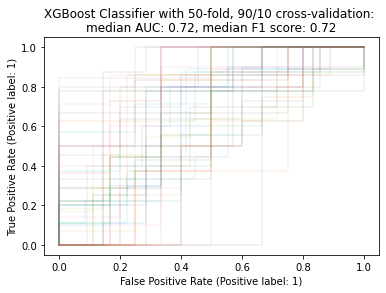

XGBoost Classifier with 50-fold, 90/10 cross-validation:
median F1 score: 0.72
median AUC: 0.72

-----
Most important features on average across the 500 trees
-----
Importance:           Feature:

0.154       L1_avg_epitope_SIN
0.075                       IE
0.075      L3_charged_aromatic
0.074         avg_paratope_SIN
0.065     L2_aromatic_aromatic
0.064 interaction_total_energy
0.063      avg_paratope_dMaSIF
0.061                 sc_total
0.061                       RE
0.055       L1_avg_epitope_AIF
0.052         avg_paratope_AIF
0.052          L2_total_dMaSIF
0.048           L1_multivalent
0.040                H3_length
0.039           L2_multivalent
0.023                L3-9,10-A

-----
PDBs for most commonly failed Antibodies with this classification scheme: 
-----
PDB:   Fail Rate:   Affinity:

5kvd        100.0%     6.58
3qwo        100.0%     7.06
4idj        100.0%     11.77
2wuc        100.0%     6.79
6b0s        100.0%     6.75
3bdy        100.0%     6.52
1sy6        100.0% 

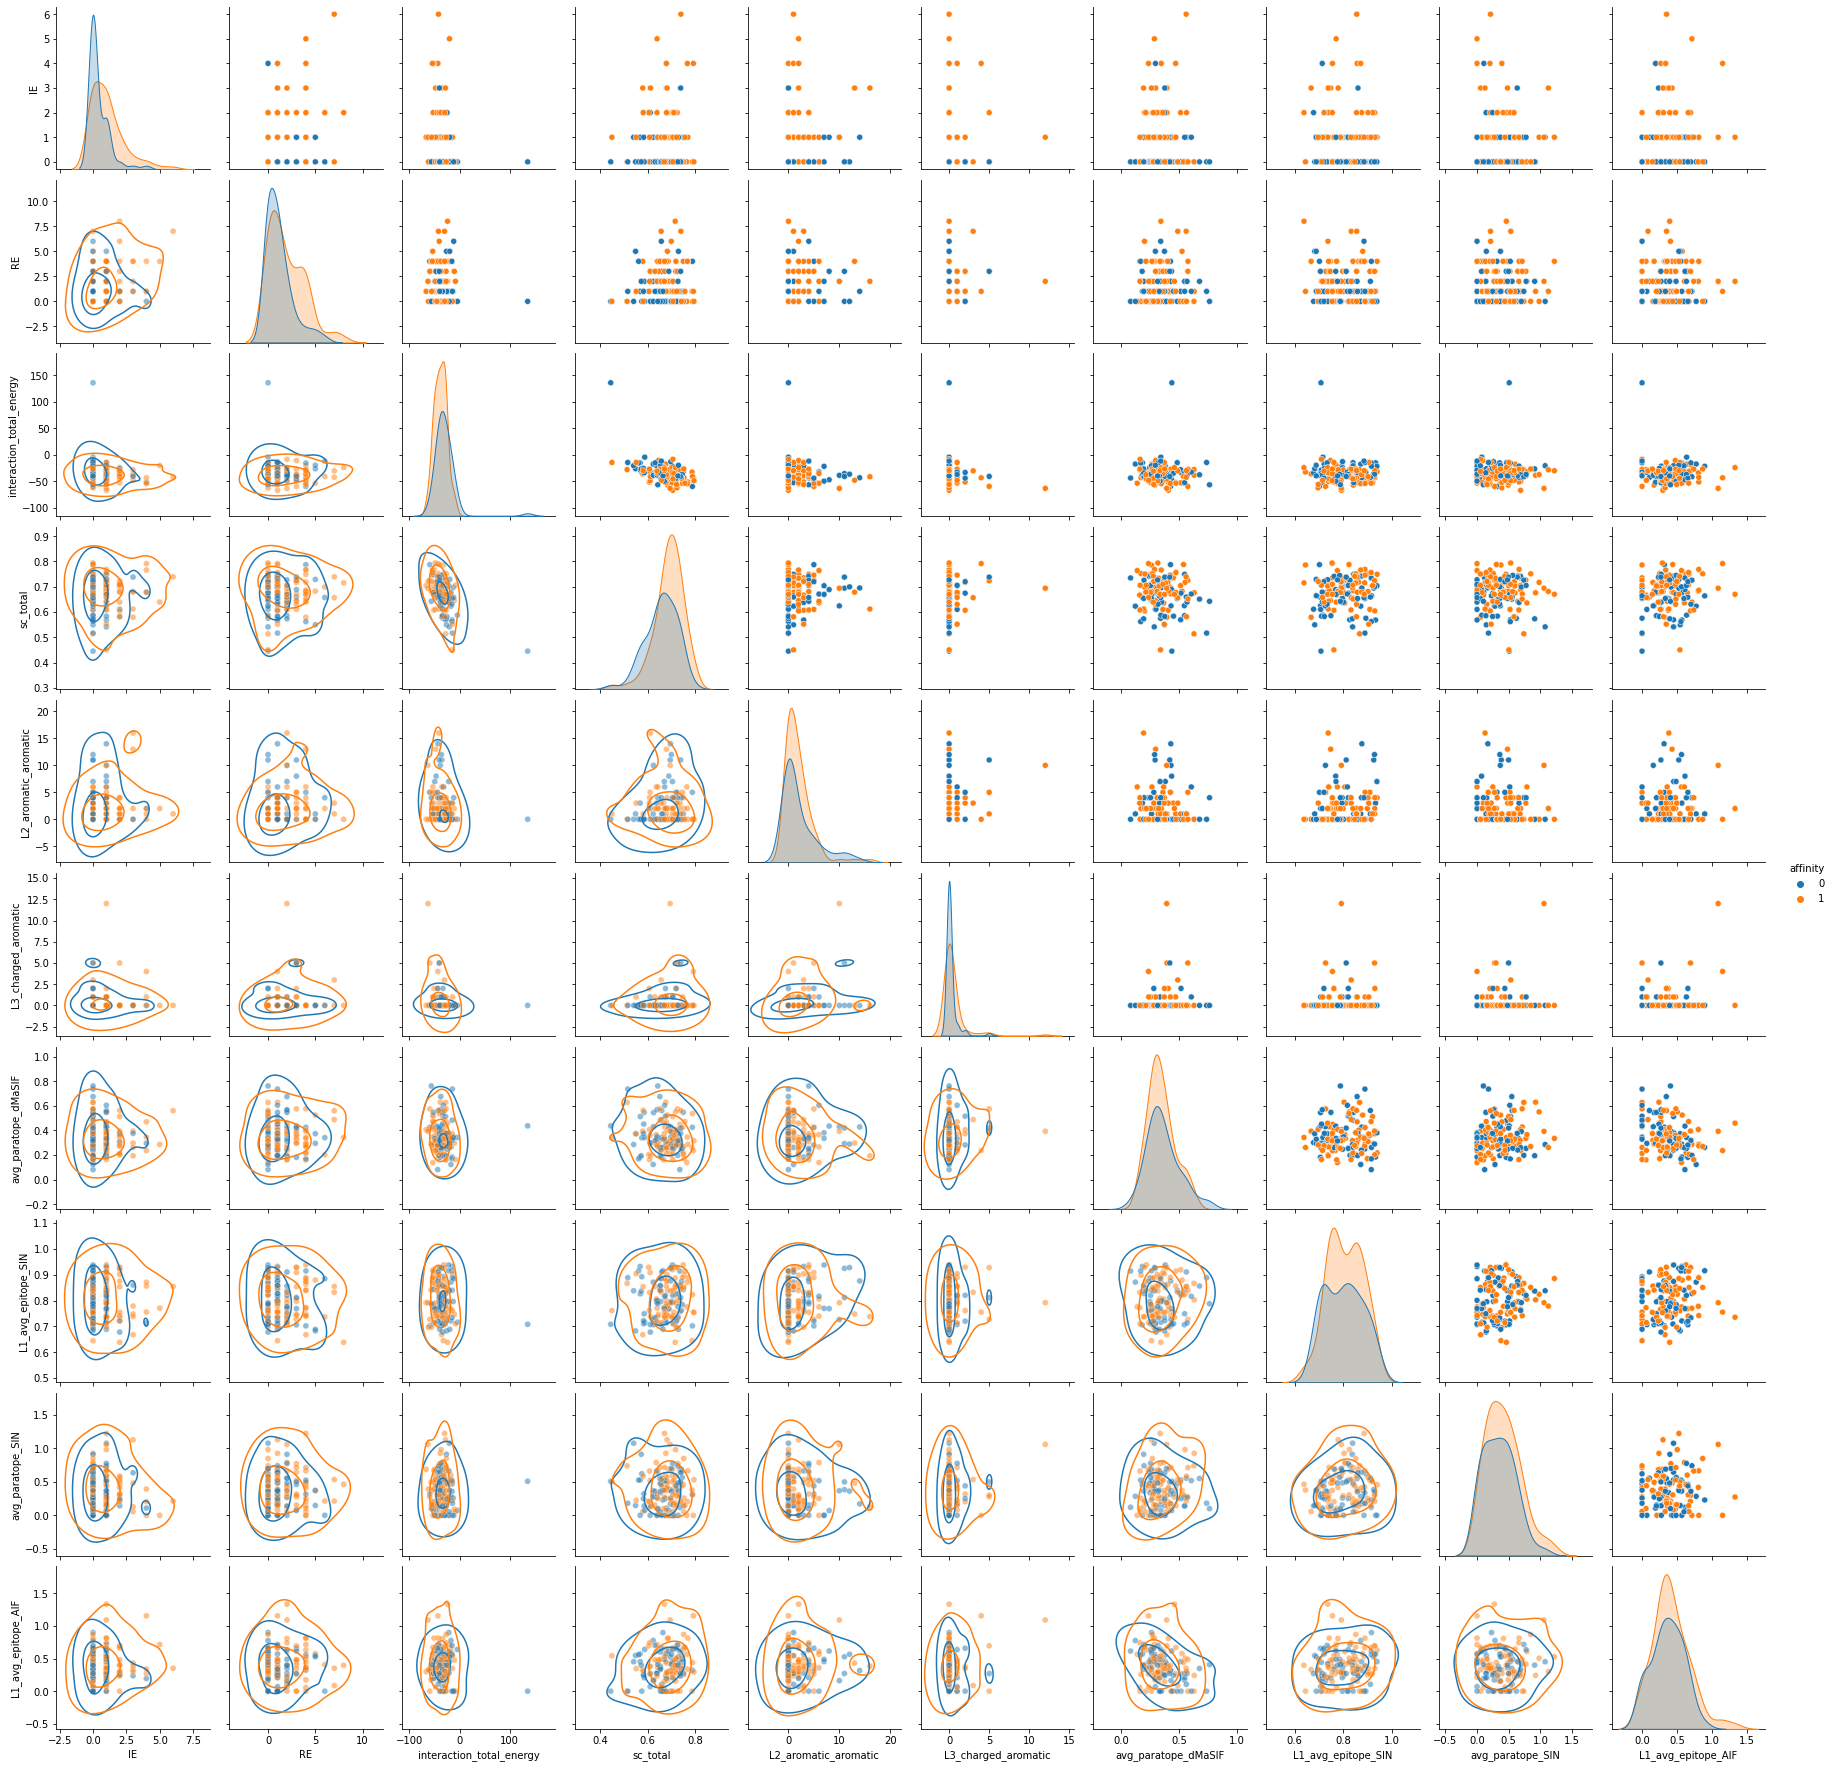

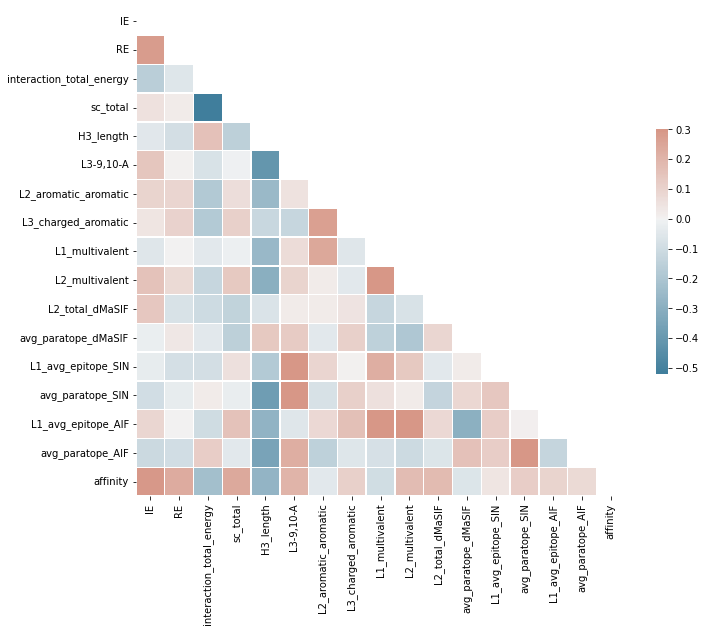

In [ ]:
#@title Classify antibodies according to high or low affinity 
#@markdown This cell implements the classifier cross-validation and outputs the results. 

#@markdown The runtime varies from <1 min to >1 hour depending on the number of features used, the result reporting options, and the classifier architecture. Default settings should run in <5min.

# Imports
import sklearn as skl
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, f1_score
from scipy.stats import spearmanr
from sklearn.feature_selection import f_classif, mutual_info_classif, mutual_info_regression, f_regression, r_regression, SelectFpr, SelectFdr
import seaborn as sns
import collections

#@markdown Affinity cutoff for classifier, reported as -log10(affinity) such than 1nM is "9"
affinity_cutoff = 9 #@param {type:"slider", min: 6, max:12, step:0.5} #dataset median is 8.5
#@markdown Parition size during cross-validation (e.g., n_splits = 10 for 90/10 train/cross-validate) 
n_splits = 10 #@param {type:"slider", min: 5, max:10, step:1}
#@markdown Number of times to repeat cross-validation
n_fold = 50 #@param {type:"slider", min: 5, max:50, step:5}
#@markdown Remove antibodies with intermediate affinity (1e-7.5 to 1e-9.5; dataset median KD=1e-8.5) during training and/or testing?
MDO_set = True #@param {type:"boolean"}
Middle_set = False #@param {type:"boolean"}
#@markdown Remove homologous antibodies from the training set? They are always removed from test set to prevent data leakage
remove_homologous_Abs = True #@param {type:"boolean"}
#@markdown Remove nanobodies from dataset for training and testing?
remove_Nb = True #@param {type:"boolean"}
#@markdown Select feature-sets to be used by the classifier
aa_counts = True #@param {type:"boolean"}
aa_counts_CDR = True #@param {type:"boolean"}
energetics_pyrosetta = True #@param {type:"boolean"}
Ab_info = True #@param {type:"boolean"}
#Truss = False #@param {type:"boolean"}
Truss = False # deprecated
multivalent_interactions = True #@param {type:"boolean"}
dMaSIF_site = True #@param {type:"boolean"}
SIN = True #@param {type:"boolean"}
AIF = True #@param {type:"boolean"}
#@markdown Use a feature selector to pick top features from the selected feature-sets?
use_feature_selector = False #@param {type:"boolean"}
num_features = 10 #@param {type:"number"}
selector_metric = f_classif #@param ["f_classif",'mutual_info_classif','mutual_info_regression','f_regression','r_regression']{type:"raw"}
#@markdown Alternatively, use a feature-selector to choose x features from each feature-set?
use_feature_selector_across_sets = True #@param {type:"boolean"}
num_features_across_sets = 2 #@param {type:"number"}
selector_metric = f_classif #@param ["f_classif",'mutual_info_classif','mutual_info_regression','f_regression','r_regression']{type:"raw"}
#@markdown Select classifier architecture
classifier_type = "XGBoost" #@param ["RandomForest",'XGBoost','GradientBoosting','SVC','MLP']
#@markdown Detailed reporting options
report_important_features = True #@param {type:"boolean"}
report_failed_Abs = True #@param {type:"boolean"}
if classifier_type in ['SVC','MLP']: #not supported
  report_important_features = False
  print('feature_importances unsupported for SVC or MLP implementations')

feature_variables = {
    'X_aa_counts': feats_aa_counts,
    'X_pyrosetta': feats_pyrosetta,
    'X_Ab_info': feats_Ab_info,
    'X_Truss': feats_truss,
    'X_aa_counts_CDR': feats_aa_counts_CDR,
    'X_multivalent': feats_multivalent_epitope_sites,
    'X_dMaSIF_site': feats_dMaSIF_site,
    'X_SIN': feats_SIN_CDR,
    'X_AIF': feats_AIF_CDR
}

for var_name, var_value in feature_variables.items():
    exec(f"{var_name} = np.vstack(var_value)")

feats_to_use = [] 
used_feat = ''
all_features = []

feature_options = {
    'aa_counts': (X_aa_counts, all_cols[0]),
    'energetics_pyrosetta': (X_pyrosetta, all_cols[2]),
    'Ab_info': (X_Ab_info, all_cols[3]),
    'Truss': (X_Truss, all_cols[4]),
    'aa_counts_CDR': (X_aa_counts_CDR, all_cols[1]),
    'multivalent_interactions': (X_multivalent, all_cols[5]),
    'dMaSIF_site': (X_dMaSIF_site, all_cols[6]),
    'SIN': (X_SIN, all_cols[7]),
    'AIF': (X_AIF, all_cols[8])
}

start_index = 0
for feature, (var, cols) in feature_options.items():
    if eval(feature):
        n_cols = var.shape[1]
        feats_to_use.append(list(range(start_index, start_index+n_cols)))
        used_feat += f'{feature}, '
        all_features.append(cols)
        start_index += n_cols

all_features = sum(all_features, []) 
feats_to_use = [item for items in feats_to_use for item in items]

y = np.array(y_final)
X = np.concatenate((X_aa_counts,X_pyrosetta,X_Ab_info,X_Truss,X_aa_counts_CDR,X_multivalent,X_dMaSIF_site,X_SIN, X_AIF), axis=1)
pdb_list = np.array(track_pdb_ids)
X = X[:,feats_to_use] 
X = np.nan_to_num(X)

# Remove Nb or not
if remove_Nb:
    y = y[~np.isnan(X_Ab_info[:,2])] # feature #3 is CDR-L3 length
    X = X[~np.isnan(X_Ab_info[:,2]),:] # eliminates VHH 
    pdb_list = pdb_list[~np.isnan(X_Ab_info[:,2])]
    used_set = 'Abs'
else:
    X = np.nan_to_num(X)
    used_set = 'Abs and Nbs'

# Print information
print(f'Classifying {X.shape[0]} {used_set} from a potential set of {X.shape[1]} features, derived from the following feature-sets:')
print(used_feat[:-2])

# Feature selection
if use_feature_selector and not use_feature_selector_across_sets:
  print(f'Selecting {num_features} features via: {selector_metric[10:-19]}')

if use_feature_selector_across_sets:
  print(f'Selecting {num_features_across_sets} features from each of the 8 feature-sets via: {str(selector_metric)[10:-19]}')

# preprocess dataset
X_df = X
if classifier_type == 'MLP':
    X_df =  StandardScaler().fit_transform(X_df)
yreg = y
y_df = (yreg>affinity_cutoff).astype(int)

ix_MDO = np.where(np.logical_or(yreg<=7.5,yreg>=9.5))[0]
ix_middle = np.where(np.logical_and(yreg>7.5,yreg<9.5))[0]
used_pdb_list = pdb_list 
ix_unique = np.array([i for i, val in enumerate(used_pdb_list) if val not in duplicate_to_del])

if report_failed_Abs:
    failed_pdbs = []
    used_pdb_list = []
    
    for i in df.index: 
        if df.loc[i,'pdb_id'] not in list(df_pyrosetta_relaxed.index):
            continue 
        else: 
            if (df['l3_length'].loc[i] > 0) and remove_Nb:
                used_pdb_list.append(df.loc[i,'pdb_id'])

# functions
def store_top_features(report_important_features, clf, all_features, all_features_selected, use_feature_selector, use_feature_selector_across_sets):
    if not report_important_features:
        return []

    feature_importances = []
    rf = clf

    for k in range(len(rf.feature_importances_)):
        if use_feature_selector or use_feature_selector_across_sets:
            feature_importances += [{'feature': all_features_selected[k], 'importance': rf.feature_importances_[k]}]
        else:
            feature_importances += [{'feature': all_features[k], 'importance': rf.feature_importances_[k]}]

    feature_importances = pd.DataFrame.from_records(feature_importances)
    return feature_importances

def store_failed_Abs(report_failed_Abs, clf, X_test, y_test, ix_test, used_pdb_list):
    if not report_failed_Abs:
        return []

    i_success = ix_test[y_test == clf.predict(X_test)] #Indices with correct prediction 
    i_fail = ix_test[~(y_test == clf.predict(X_test))] #Indices with error prediction 
    failed_pdbs = [used_pdb_list[i] for i in i_fail]

    return failed_pdbs

def feature_selector_all(X_train, y_train, X_test, all_features, selector_metric, num_features):
  selector = SelectKBest(score_func=selector_metric, k=num_features)
  X_train, X_test = selector.fit_transform(X_train,y_train), selector.transform(X_test)
  all_features_selected = selector.get_feature_names_out(all_features)
  return X_train, X_test, all_features_selected

def feature_selector_sets(selector_metric, num_features_across_sets, X_aa_counts, X_Ab_info, X_pyrosetta, X_aa_counts_CDR, X_multivalent, X_dMaSIF_site, X_SIN, X_AIF, ix_train, y_train, ix_test, all_features):
  x_tmp = X_aa_counts[~np.isnan(X_Ab_info[:,2]),:]
  selector = SelectKBest(score_func=selector_metric, k=num_features_across_sets)
  X_train = selector.fit_transform(x_tmp[ix_train,:],y_train)
  X_test = selector.transform(x_tmp[ix_test,:])
  feat_i = x_tmp.shape[1]
  all_features_selected = selector.get_feature_names_out(all_features[0:feat_i])

  for x_tmp in [X_pyrosetta, X_Ab_info, X_aa_counts_CDR, X_multivalent, X_dMaSIF_site, X_SIN, X_AIF]:
    x_tmp = x_tmp[~np.isnan(X_Ab_info[:,2]),:]

    if x_tmp.shape[1] < num_features_across_sets:
      selector = SelectKBest(score_func=selector_metric, k='all')
    else:
      selector = SelectKBest(score_func=selector_metric, k=num_features_across_sets)

    X_train_tmp = selector.fit_transform(np.nan_to_num(x_tmp[ix_train,:]),y_train)
    X_test_tmp = selector.transform(np.nan_to_num(x_tmp[ix_test,:]))
    feat_j = feat_i + x_tmp.shape[1]
    all_features_selected_tmp = selector.get_feature_names_out(all_features[feat_i : feat_j])
    feat_i += x_tmp.shape[1]
    X_train = np.concatenate((X_train, X_train_tmp), axis=1)
    X_test = np.concatenate((X_test, X_test_tmp), axis=1)
    all_features_selected = np.concatenate((all_features_selected, all_features_selected_tmp), axis=0)

  return X_train, X_test, all_features_selected

def refine_dataset(MDO_set, Middle_set, remove_homologous_Abs, ix_train, ix_test, ix_MDO, ix_middle, ix_unique, pdb_list, X_df, y_df, yreg):
    if MDO_set and Middle_set:
        pass 
    elif MDO_set:
        ix_train, ix_test = np.intersect1d(ix_train,ix_MDO), np.intersect1d(ix_test,ix_MDO)
    elif Middle_set:
        ix_train, ix_test = np.intersect1d(ix_train,ix_middle), np.intersect1d(ix_test,ix_middle)
    if remove_homologous_Abs:
        ix_test, ix_train = np.intersect1d(ix_test,ix_unique), np.intersect1d(ix_train,ix_unique)

    train_pdbs, test_pdbs = pdb_list[ix_train], pdb_list[ix_test]
    X_train, y_train, y_train_raw = X_df[ix_train,:], y_df[ix_train], yreg[ix_train]
    X_test, y_test = X_df[ix_test,:], y_df[ix_test]
    
    return train_pdbs, test_pdbs, X_train, y_train, y_train_raw, X_test, y_test, ix_train, ix_test

def build_classifier(classifier_type, n_splits, n):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state = n*42)

    classifier_mapping = {'RandomForest': RandomForestClassifier(n_estimators = 100),
                          'GradientBoosting': GradientBoostingClassifier(),
                          'MLP': MLPClassifier(),
                          'SVC': SVC(probability=True),
                          'XGBoost': xgb.XGBClassifier(objective="binary:logistic", random_state = n*42)}
    
    clf = classifier_mapping.get(classifier_type)

    return kf, classifier_mapping, clf

def plot_roc_curve(clf, X_test, y_test, n, i, svc_disp, all_AUCs):
    
    if len(set(y_test)) > 1: # AUC not defined for single class
        all_AUCs +=[roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])]
    if i == 0 and n == 0:
        svc_disp = skl.metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test, alpha=0.1)
    elif i == 0:
        svc_disp = skl.metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test, ax = svc_disp.ax_, alpha=0.1)
    
    return all_AUCs, svc_disp


all_AUCs = []
all_scores = []
all_spearmans = []
dfs_ = []
warnings.filterwarnings("ignore")

# n_fold cross-validation 
for n in range(n_fold):
  
    kf, classifier_mapping, clf = build_classifier(classifier_type, n_splits, n)
    
    # individual cross-validation 
    i = 0
    for ix_train, ix_test in kf.split(X_df):

        # dataset refinement based on user settings
        train_pdbs, test_pdbs, X_train, y_train, y_train_raw, X_test, y_test, ix_train, ix_test = refine_dataset(MDO_set, Middle_set, remove_homologous_Abs, ix_train, ix_test, ix_MDO, ix_middle, ix_unique, pdb_list, X_df, y_df, yreg)

        # feature selector pulling from all sets
        if use_feature_selector and (X.shape[1] > num_features):
          X_train, X_test, all_features_selected = feature_selector_all(X_train, y_train, X_test, all_features, selector_metric, num_features)
        elif use_feature_selector:
          all_features_selected = all_features

        # feature selector pulling from each set
        if use_feature_selector_across_sets:
          X_train, X_test, all_features_selected = feature_selector_sets(selector_metric, num_features_across_sets, X_aa_counts, X_Ab_info, X_pyrosetta, X_aa_counts_CDR, X_multivalent, X_dMaSIF_site, X_SIN, X_AIF, ix_train, y_train, ix_test, all_features)
            
        # train classifier 
        clf.fit(X_train, y_train)

        # get performance and AUC plots
        all_spearmans+=[spearmanr(clf.predict_proba(X_test)[:,1],y[ix_test])[0]]
        all_scores += [f1_score(y_test, clf.predict(X_test))]   
        if n == 0 and i == 0:
          svc_disp = None
        all_AUCs, svc_disp = plot_roc_curve(clf, X_test, y_test, n, i, svc_disp, all_AUCs)
        i +=1 

        # store top features
        feature_importances = store_top_features(report_important_features, clf, all_features, all_features_selected, use_feature_selector, use_feature_selector_across_sets)
        dfs_ += [feature_importances]

        # store failed Abs 
        failed_pdbs.append(store_failed_Abs(report_failed_Abs, clf, X_test, y_test, ix_test, used_pdb_list))

# plot AUC curve        
svc_disp.ax_.get_legend().remove()
fract_tmp = int(100 / n_splits)
plt.title(classifier_type + ' Classifier with ' + str(n_fold) + '-fold, ' + str(100-fract_tmp) + '/' + str(fract_tmp) + ' cross-validation:' + 
            ' \n' + 'median AUC: '+str(round(np.median(all_AUCs),2)) + ', median F1 score: '+str(round(np.median(all_scores),2)))

# Save result
save_output_results = True 
if save_output_results:
  if use_feature_selector: 
    tmp_path = '/content/protein_interactions/Antibody_DB/logs/Results/nm_{}_{}_{}_{}_v0'.format(num_features, used_feat[:-2].replace("_", "").replace(", ", "_"),n,n_splits)
  else:
    tmp_path = '/content/protein_interactions/Antibody_DB/logs/Results/nm_{}_{}_{}_v0'.format(used_feat[:-2].replace("_", "").replace(", ", "_"),n,n_splits)
  plt.savefig(tmp_path + '.png', dpi=300,bbox_inches = "tight")
plt.show()

# Report result
print(classifier_type + ' Classifier with ' + str(n_fold) + '-fold, ' + str(100-fract_tmp) + '/' + str(fract_tmp) + ' cross-validation:')
print('median F1 score: '+str(round(np.median(all_scores),2)))
print('median AUC: '+str(round(np.median(all_AUCs),2)))

if report_important_features and (classifier_type != 'MLP'):
  df_feat_summary = pd.concat(dfs_).groupby('feature',level=0).mean()
  df_feat_summary['feature'] = feature_importances['feature']
  df_feat_summary = df_feat_summary.sort_values('importance',ascending=False)
  df_feat_summary['importance'] = np.round(df_feat_summary['importance'],3)
  print('')
  print('-----')
  print('Most important features on average across the ' + str(n_fold*n_splits) + ' trees') 
  print('-----')
  print('Importance:           Feature:')
  print('')
  print(df_feat_summary.head(20).to_string(index=False, header=False))

# report failed Abs
if report_failed_Abs:
  failed_pdbs  = sum(failed_pdbs, []) # flatten
  failed_pdbs = dict(collections.Counter(failed_pdbs)) # get frequency
  sorted_failed = {k: v for k, v in sorted(failed_pdbs.items(), reverse=True, key=lambda item: item[1])} # sort on frequency
  print('')
  print('-----')
  print('PDBs for most commonly failed Antibodies with this classification scheme: ') 
  print('-----')
  print('PDB:   Fail Rate:   Affinity:')
  print('')
  i = 0
  for k in sorted_failed:
    if i < 10:
      print(k + '        ' + str( 100*(sorted_failed[k] / (n_fold)) ) + '%     ' + str(round(-np.log10(df['affinity'].loc[df['pdb_id']==k]),2).values[0])  ) 
    i+=1

# Save reported results
if save_output_results and report_important_features and report_failed_Abs:
  df_feat_summary.to_csv(tmp_path + '.csv')
  (pd.DataFrame.from_dict(sorted_failed, orient='index')).to_csv(tmp_path + '_failed_Abs.csv')

# Feature plotting 
if report_important_features and (classifier_type != 'MLP'):

  # pair plots
  num_top_feat_to_plot = 10
  X_labeled = pd.DataFrame(X_df, columns=all_features)
  X_labeled = X_labeled[X_labeled.columns.drop(list(X_labeled.filter(regex='None')))] #catch for missing cononical CDR labels
  X_labeled_selected = X_labeled[X_labeled.columns.intersection(list(df_feat_summary.head(num_top_feat_to_plot)['feature']))] #all_features_selected
  X_labeled_selected['affinity'] = y_df
  X_labeled_selected = X_labeled_selected.loc[list(ix_train)+list(ix_test)]
  g = sns.pairplot(X_labeled_selected, plot_kws=dict(alpha=0.5), hue='affinity', diag_kind="kde")
  g.map_lower(sns.kdeplot, levels=3, bw_adjust=1.5)
  g.map_upper(sns.scatterplot)

  if save_output_results:
    tmp_path = '/content/protein_interactions/Antibody_DB/logs/Results/pairplot_{}_{}_{}_{}_v0'.format(num_features, used_feat[:-2].replace("_", "").replace(", ", "_"),n_fold,n_splits)
    plt.savefig(tmp_path + '.png', dpi=300,bbox_inches = "tight")

  # corr plots
  X_labeled_selected_corr = X_labeled[X_labeled.columns.intersection(list(df_feat_summary['feature']))] #all_features_selected
  X_labeled_selected_corr['affinity'] = y_df
  X_labeled_selected_corr = X_labeled_selected_corr.loc[list(ix_train)+list(ix_test)]
  corr = X_labeled_selected_corr.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  f, ax = plt.subplots(figsize=(11, 9))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})
  
  if save_output_results:
    tmp_path = '/content/protein_interactions/Antibody_DB/logs/Results/corrplot_{}_{}_{}_{}_v0'.format(num_features, used_feat[:-2].replace("_", "").replace(", ", "_"),n_fold,n_splits)
    plt.savefig(tmp_path + '.png', dpi=300, bbox_inches = "tight")



Classifiying 356 Abs from a potential set of 400 features, derived from the following feature-sets:
aa_counts
Selecting 10 features via: f_classif


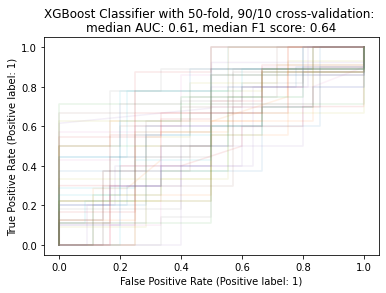

XGBoost Classifier with 50-fold, 90/10 cross-validation:
median F1 score: 0.64
median AUC: 0.61

-----
Most important features on average across the 500 trees
-----
Importance:           Feature:

0.135 AS
0.121 GE
0.119 HR
0.110 IE
0.100 NI
0.090 RE
0.083 WG
0.082 TE
0.081 WS
0.080 YF

-----
PDBs for most commonly failed Antibodies with this classification scheme: 
-----
PDB:   Fail Rate:   Affinity:

3h42        100.0%     11.4
3gjf        100.0%     7.2
4uu9        100.0%     10.85
1sy6        100.0%     5.56
1p2c        100.0%     10.01
3k2u        100.0%     9.8
3hae        98.0%     7.34
5mes        96.0%     6.47
1fe8        96.0%     5.7
6b0s        94.0%     6.75
Classifiying 356 Abs from a potential set of 150 features, derived from the following feature-sets:
aa_counts_CDR
Selecting 10 features via: f_classif


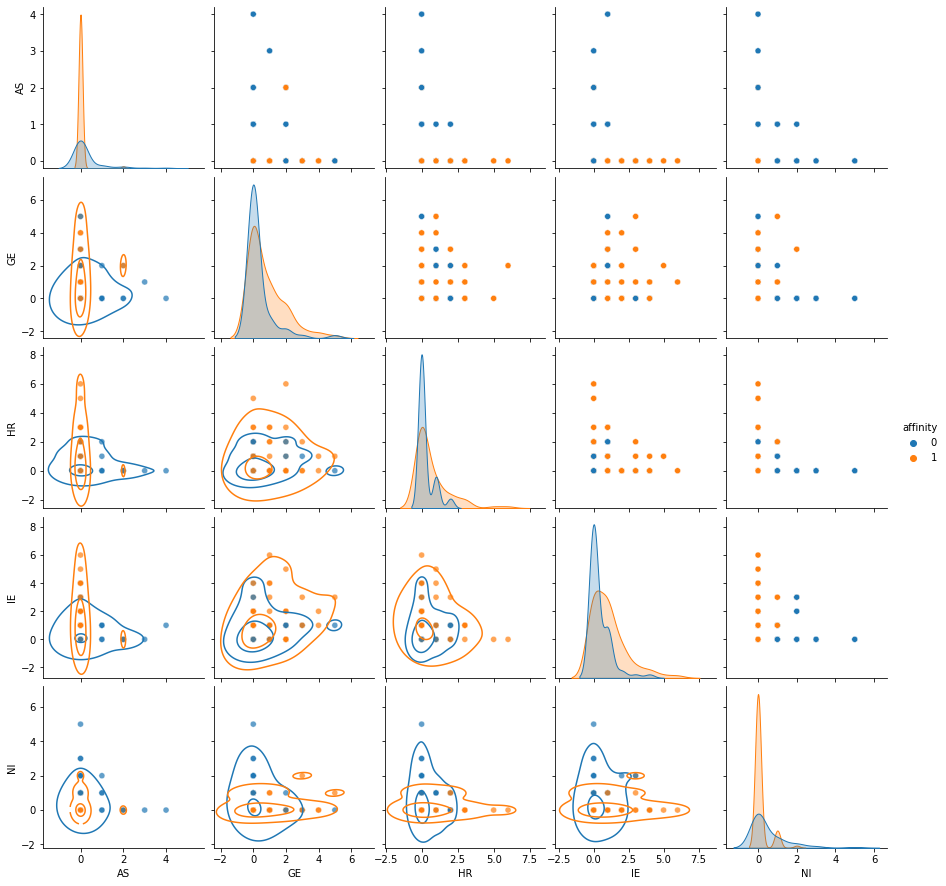

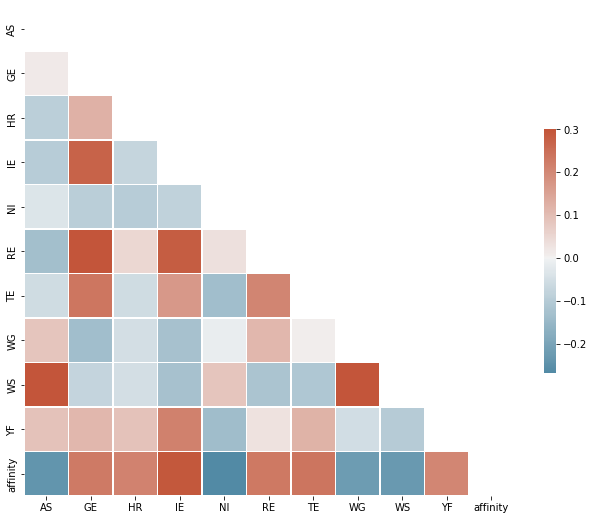

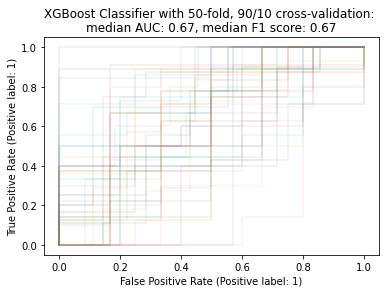

XGBoost Classifier with 50-fold, 90/10 cross-validation:
median F1 score: 0.67
median AUC: 0.67

-----
Most important features on average across the 500 trees
-----
Importance:           Feature:

0.116 L3_hydrophobic_charged
0.113     L3_special_charged
0.103    L3_charged_aromatic
0.102     L2_special_charged
0.101   L3_aromatic_aromatic
0.095       H1_polar_charged
0.095    L2_aromatic_charged
0.095      H3_aromatic_polar
0.092   L2_aromatic_aromatic
0.088    H1_aromatic_charged

-----
PDBs for most commonly failed Antibodies with this classification scheme: 
-----
PDB:   Fail Rate:   Affinity:

4k2u        100.0%     10.82
4idj        100.0%     11.77
5mes        100.0%     6.47
5gzo        100.0%     6.79
3mac        100.0%     6.7
1mlc        100.0%     7.04
2wuc        100.0%     6.79
5anm        100.0%     11.71
6b0s        100.0%     6.75
5c6t        98.0%     9.89
Classifiying 356 Abs from a potential set of 18 features, derived from the following feature-sets:
energetics_pyr

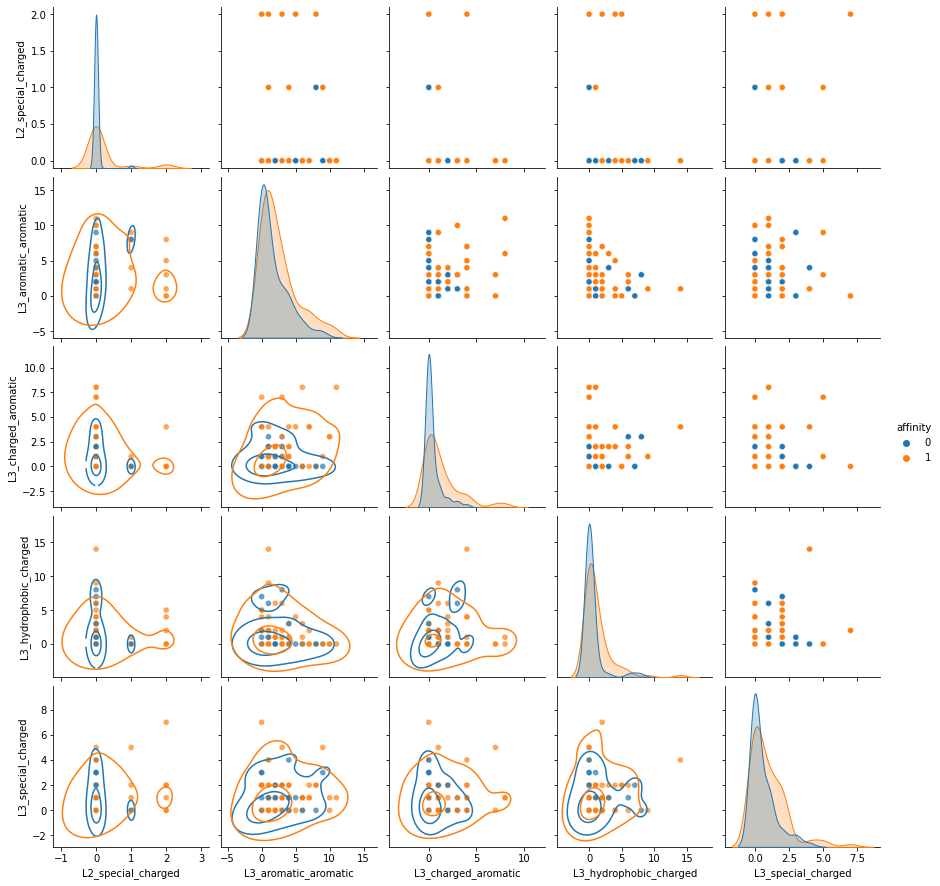

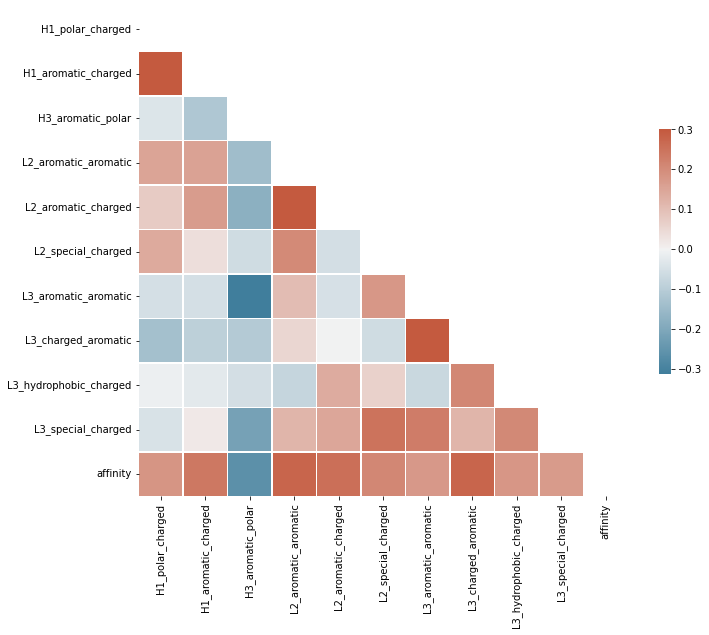

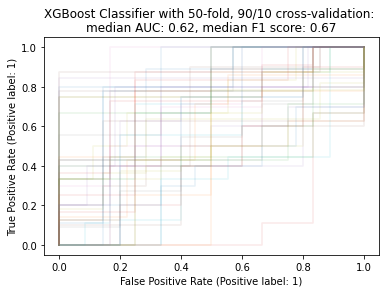

XGBoost Classifier with 50-fold, 90/10 cross-validation:
median F1 score: 0.67
median AUC: 0.62

-----
Most important features on average across the 500 trees
-----
Importance:           Feature:

0.121         interaction_total_energy
0.119                         sc_total
0.110                            dSASA
0.108             epitope_total_energy
0.103                     interface_dg
0.094            h3_interaction_energy
0.091            l3_interaction_energy
0.087            h1_interaction_energy
0.085 separated_interface_energy_ratio
0.082            h2_interaction_energy

-----
PDBs for most commonly failed Antibodies with this classification scheme: 
-----
PDB:   Fail Rate:   Affinity:

3qwo        100.0%     7.06
5i5k        100.0%     10.75
5dwu        100.0%     7.31
6b0e        100.0%     7.39
3gjf        100.0%     7.2
3hi6        100.0%     5.33
1nsn        100.0%     10.0
5anm        100.0%     11.71
3ve0        100.0%     5.71
3t2n        100.0%     7.4
Classifiying 3

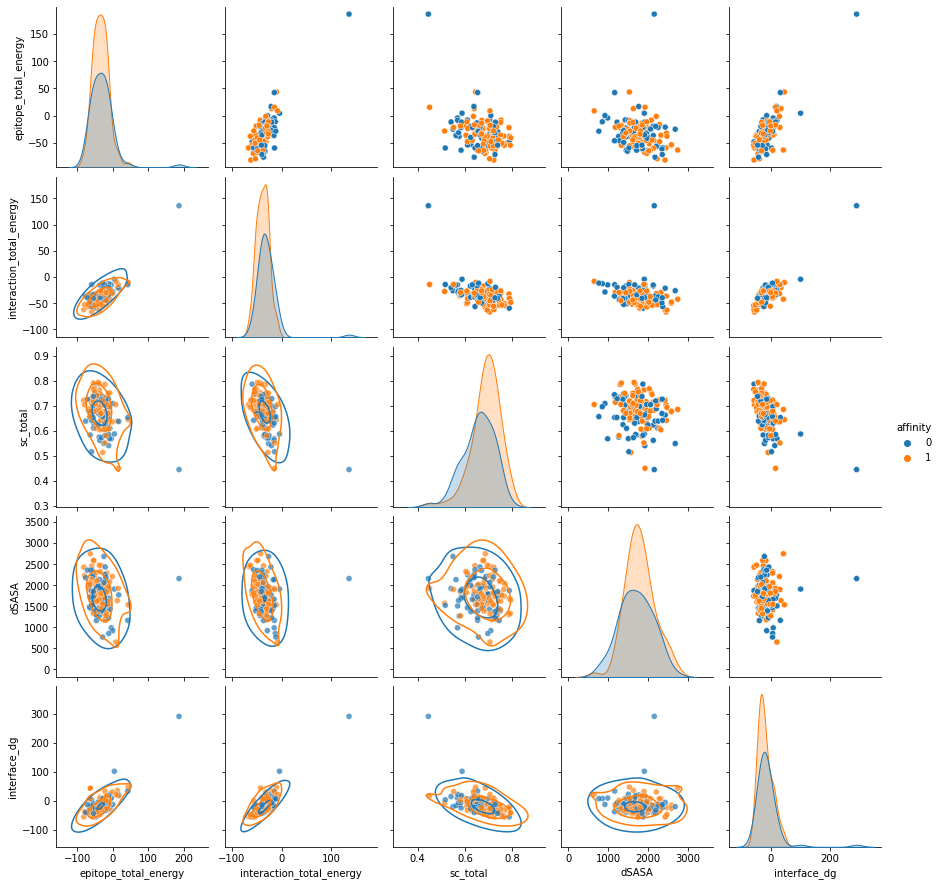

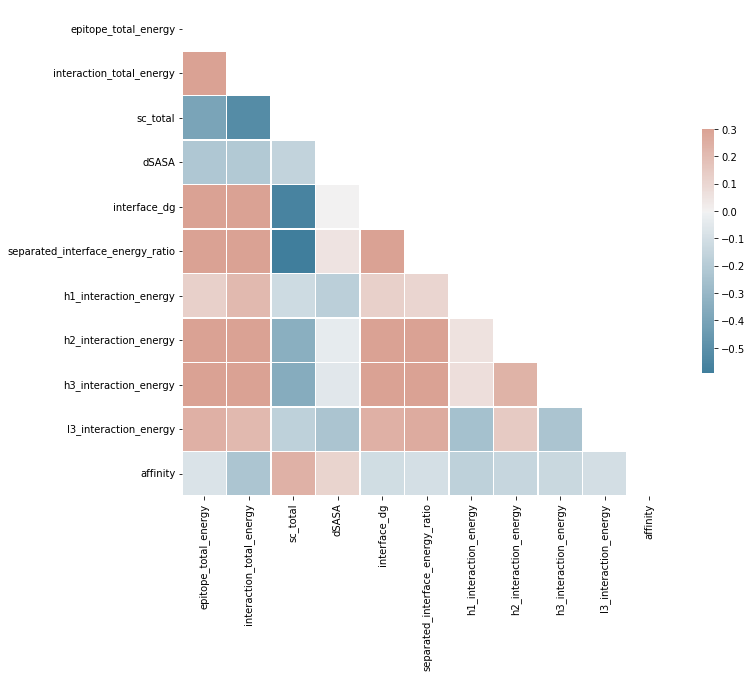

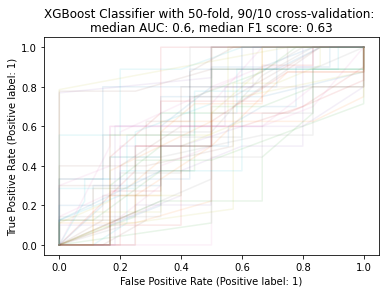

XGBoost Classifier with 50-fold, 90/10 cross-validation:
median F1 score: 0.63
median AUC: 0.6

-----
Most important features on average across the 500 trees
-----
Importance:           Feature:

0.306 H3_length
0.191 L3-9,10-A
0.122   L1-12-B
0.097      None
0.093   L1-13-A
0.081    L3-5-A
0.043   H1-13-C
0.039      None
0.024   L1-14-B
0.005   L3-10-B

-----
PDBs for most commonly failed Antibodies with this classification scheme: 
-----
PDB:   Fail Rate:   Affinity:

5kvd        100.0%     6.58
3a6b        100.0%     6.97
4idj        100.0%     11.77
5mi0        100.0%     6.39
5dwu        100.0%     7.31
4np4        100.0%     10.72
3hi6        100.0%     5.33
4ffz        100.0%     6.38
6mft        100.0%     5.64
2j6e        100.0%     6.22
Classifiying 356 Abs from a potential set of 7 features, derived from the following feature-sets:
multivalent_interactions
Selecting 10 features via: f_classif


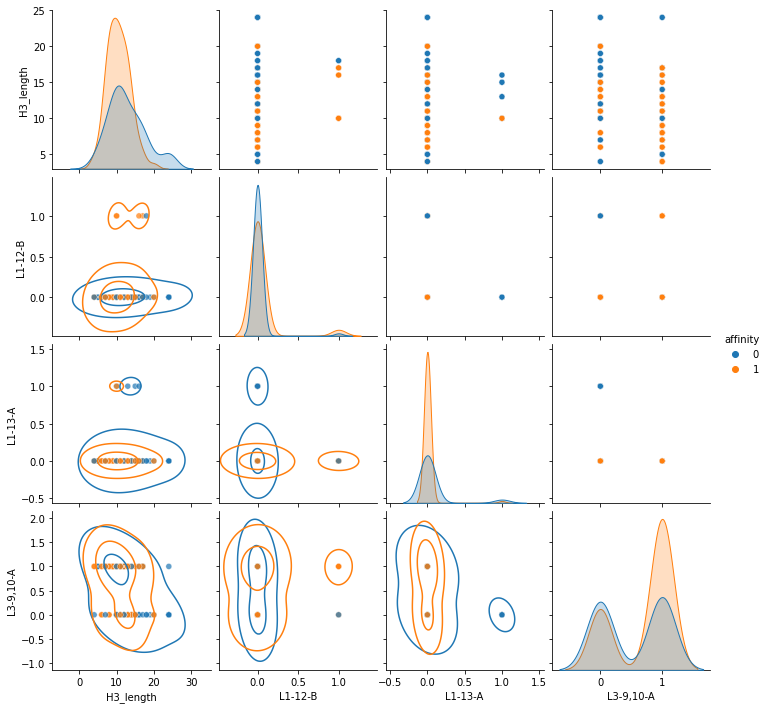

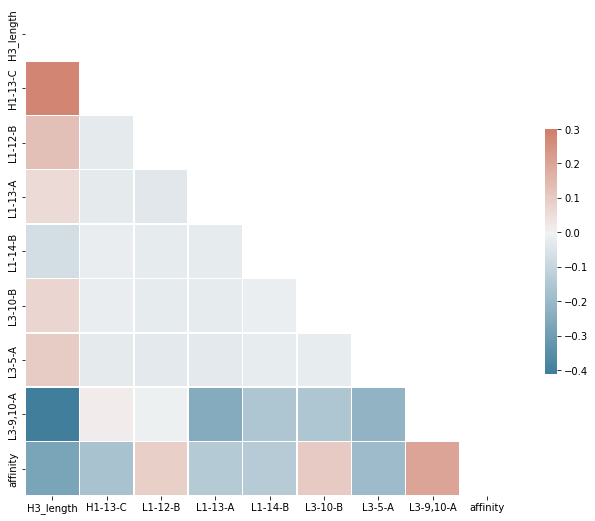

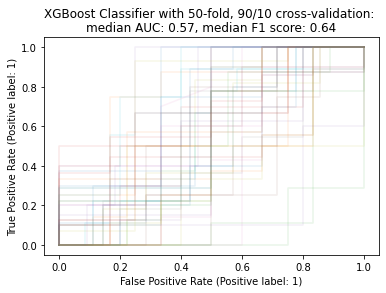

XGBoost Classifier with 50-fold, 90/10 cross-validation:
median F1 score: 0.64
median AUC: 0.57

-----
Most important features on average across the 500 trees
-----
Importance:           Feature:

0.277       L2_multivalent
0.131       L3_multivalent
0.128 num_CDRs_multivalent
0.120       L1_multivalent
0.117       H2_multivalent
0.116       H1_multivalent
0.110       H3_multivalent

-----
PDBs for most commonly failed Antibodies with this classification scheme: 
-----
PDB:   Fail Rate:   Affinity:

3c09        100.0%     7.37
5n7w        100.0%     7.1
3a6b        100.0%     6.97
5w0k        100.0%     7.16
4dgi        100.0%     6.35
4idj        100.0%     11.77
3hae        100.0%     7.34
3gjf        100.0%     7.2
4k24        100.0%     6.27
4ffz        100.0%     6.38
Classifiying 356 Abs from a potential set of 26 features, derived from the following feature-sets:
dMaSIF_site
Selecting 10 features via: f_classif


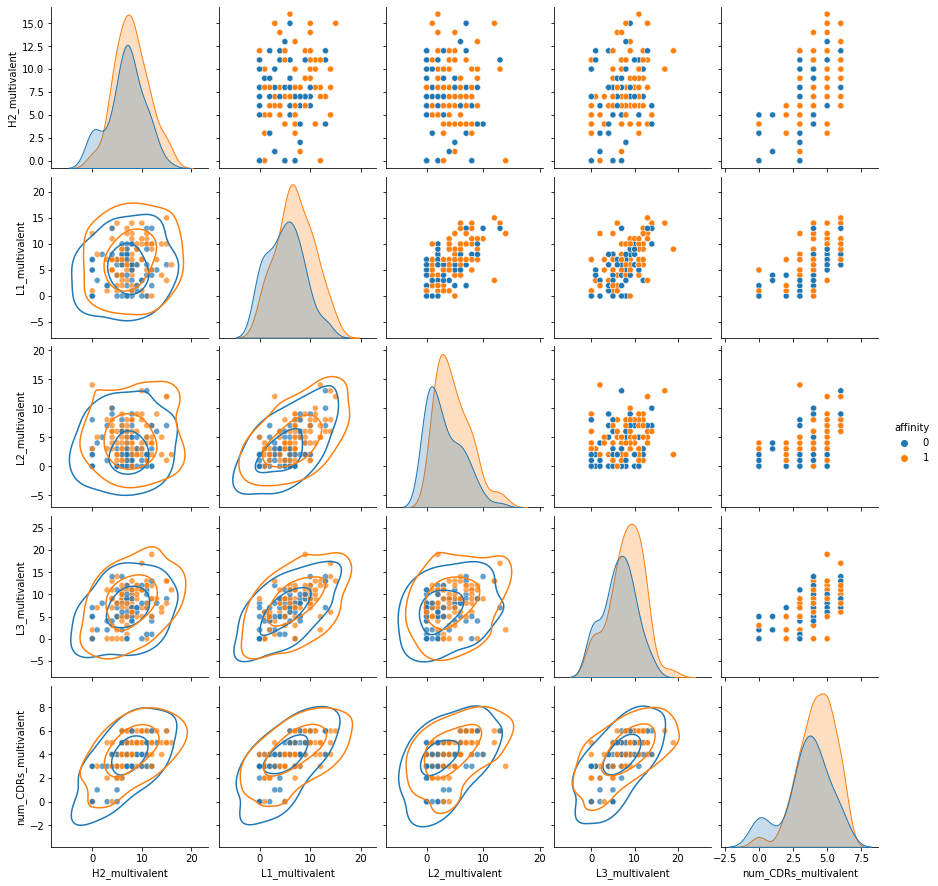

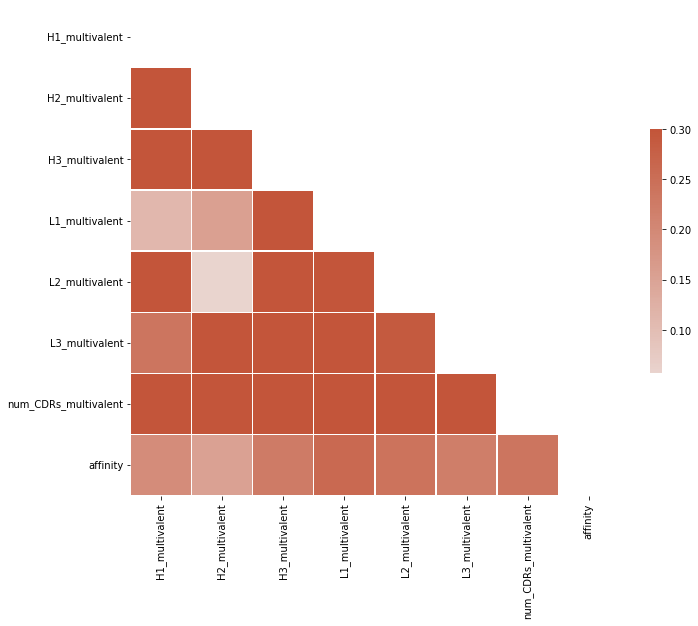

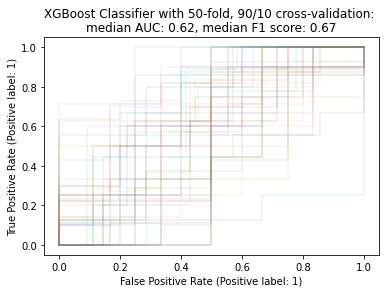

XGBoost Classifier with 50-fold, 90/10 cross-validation:
median F1 score: 0.67
median AUC: 0.62

-----
Most important features on average across the 500 trees
-----
Importance:           Feature:

0.132   L1_avg_epitope_dMaSIF
0.116      avg_epitope_dMaSIF
0.111   H3_avg_epitope_dMaSIF
0.102   L2_avg_epitope_dMaSIF
0.101         L2_total_dMaSIF
0.095 H2_total_epitope_dMaSIF
0.092     avg_paratope_dMaSIF
0.090         L3_total_dMaSIF
0.085   H2_avg_epitope_dMaSIF
0.075 H1_total_epitope_dMaSIF

-----
PDBs for most commonly failed Antibodies with this classification scheme: 
-----
PDB:   Fail Rate:   Affinity:

5kvd        100.0%     6.58
5w0k        100.0%     7.16
3dvn        100.0%     7.04
4idj        100.0%     11.77
4k24        100.0%     6.27
5u8q        100.0%     5.62
6a0z        100.0%     7.28
4uu9        100.0%     10.85
2wuc        100.0%     6.79
6ii8        98.0%     6.41
Classifiying 356 Abs from a potential set of 26 features, derived from the following feature-sets:
SIN


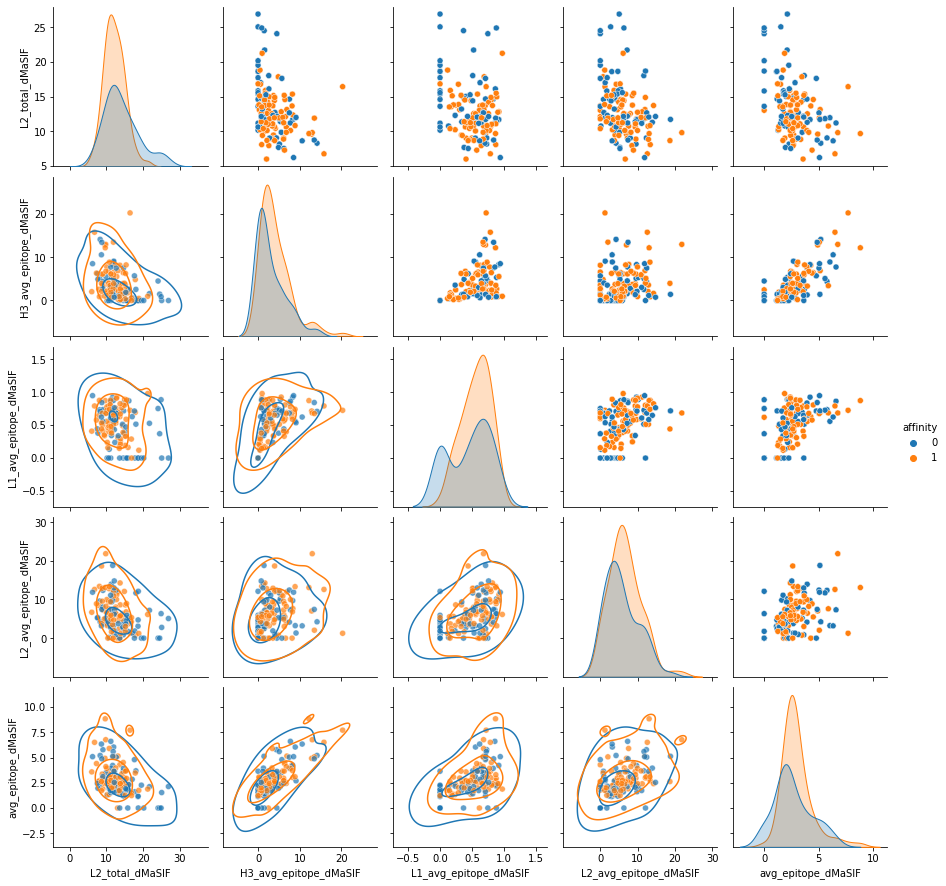

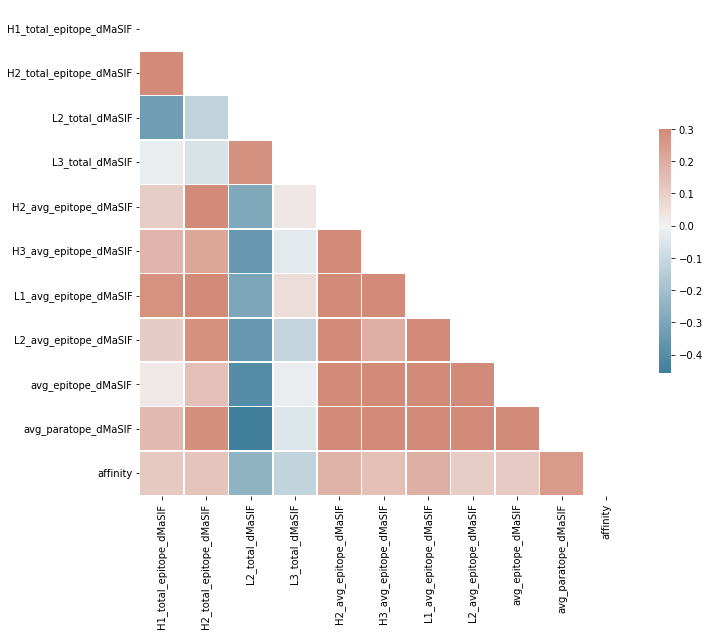

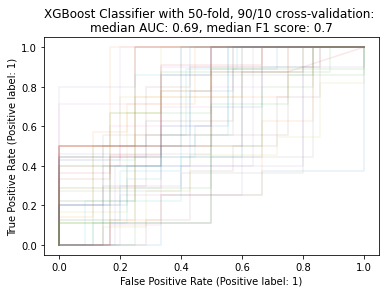

XGBoost Classifier with 50-fold, 90/10 cross-validation:
median F1 score: 0.7
median AUC: 0.69

-----
Most important features on average across the 500 trees
-----
Importance:           Feature:

0.182   L1_avg_epitope_SIN
0.130   H3_avg_epitope_SIN
0.109      avg_epitope_SIN
0.104   L2_avg_epitope_SIN
0.091     avg_paratope_SIN
0.086 H1_total_epitope_SIN
0.078   H2_avg_epitope_SIN
0.076   H1_avg_epitope_SIN
0.073           H2_avg_SIN
0.072 L2_total_epitope_SIN

-----
PDBs for most commonly failed Antibodies with this classification scheme: 
-----
PDB:   Fail Rate:   Affinity:

5kvd        100.0%     6.58
3qwo        100.0%     7.06
5d1x        100.0%     10.68
3dvn        100.0%     7.04
4idj        100.0%     11.77
4ffz        100.0%     6.38
5ywy        100.0%     7.23
3mac        100.0%     6.7
2wuc        100.0%     6.79
4r8w        100.0%     9.74
Classifiying 356 Abs from a potential set of 26 features, derived from the following feature-sets:
AIF
Selecting 10 features via: f_cl

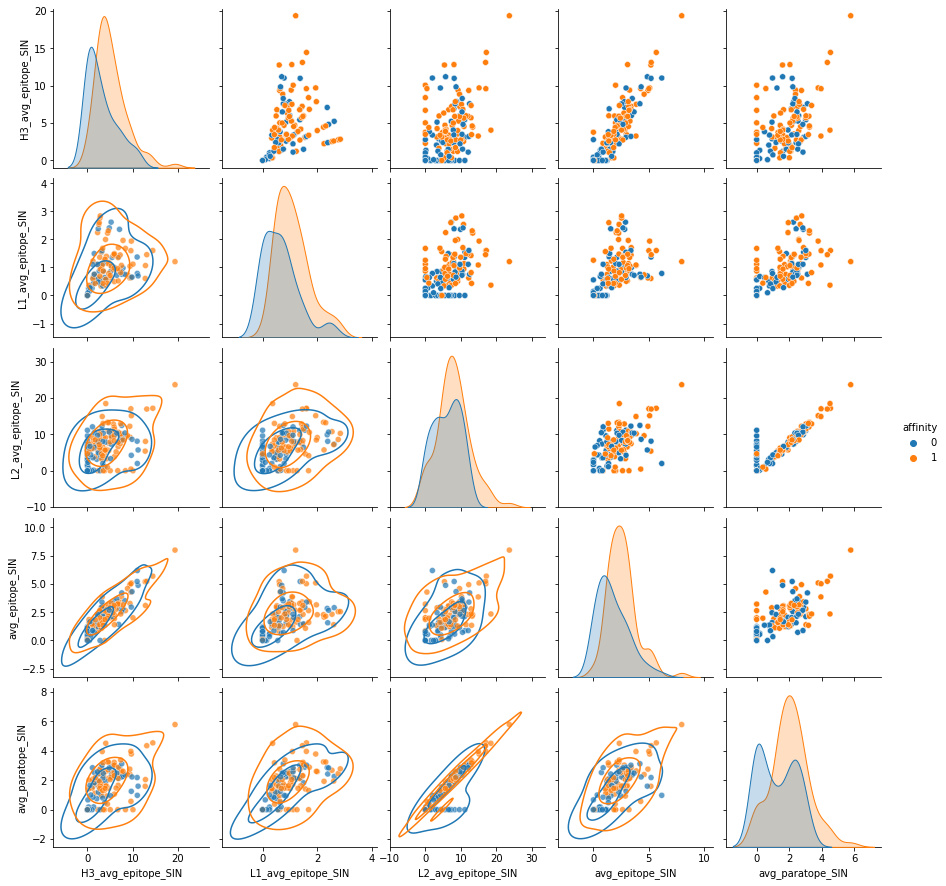

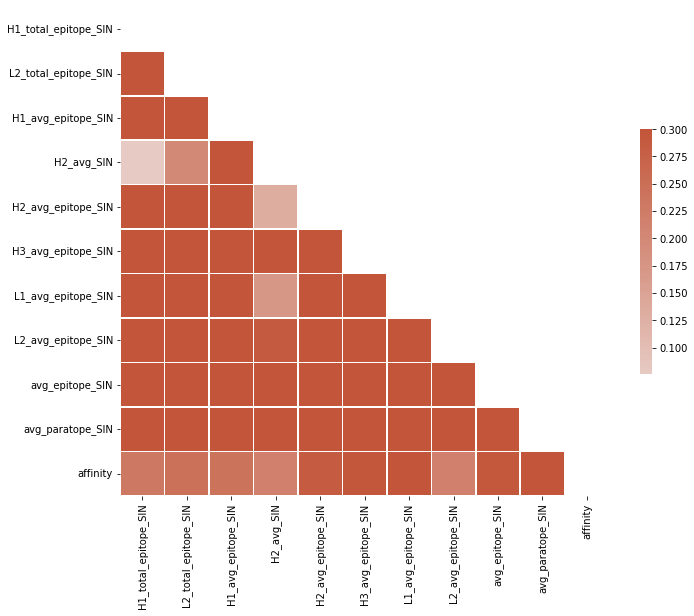

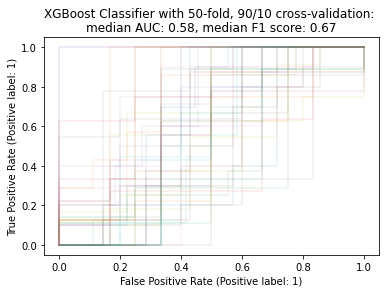

XGBoost Classifier with 50-fold, 90/10 cross-validation:
median F1 score: 0.67
median AUC: 0.58

-----
Most important features on average across the 500 trees
-----
Importance:           Feature:

0.167      avg_epitope_AIF
0.139   H3_avg_epitope_AIF
0.131   L1_avg_epitope_AIF
0.089   H2_avg_epitope_AIF
0.089   L2_avg_epitope_AIF
0.082   H1_avg_epitope_AIF
0.078 L2_total_epitope_AIF
0.078           H2_avg_AIF
0.076     avg_paratope_AIF
0.072 H1_total_epitope_AIF

-----
PDBs for most commonly failed Antibodies with this classification scheme: 
-----
PDB:   Fail Rate:   Affinity:

5kvd        100.0%     6.58
3dvn        100.0%     7.04
4idj        100.0%     11.77
4j4p        100.0%     7.4
4ffz        100.0%     6.38
5ywy        100.0%     7.23
2wuc        100.0%     6.79
4r8w        100.0%     9.74
5j13        100.0%     10.22
3ve0        100.0%     5.71


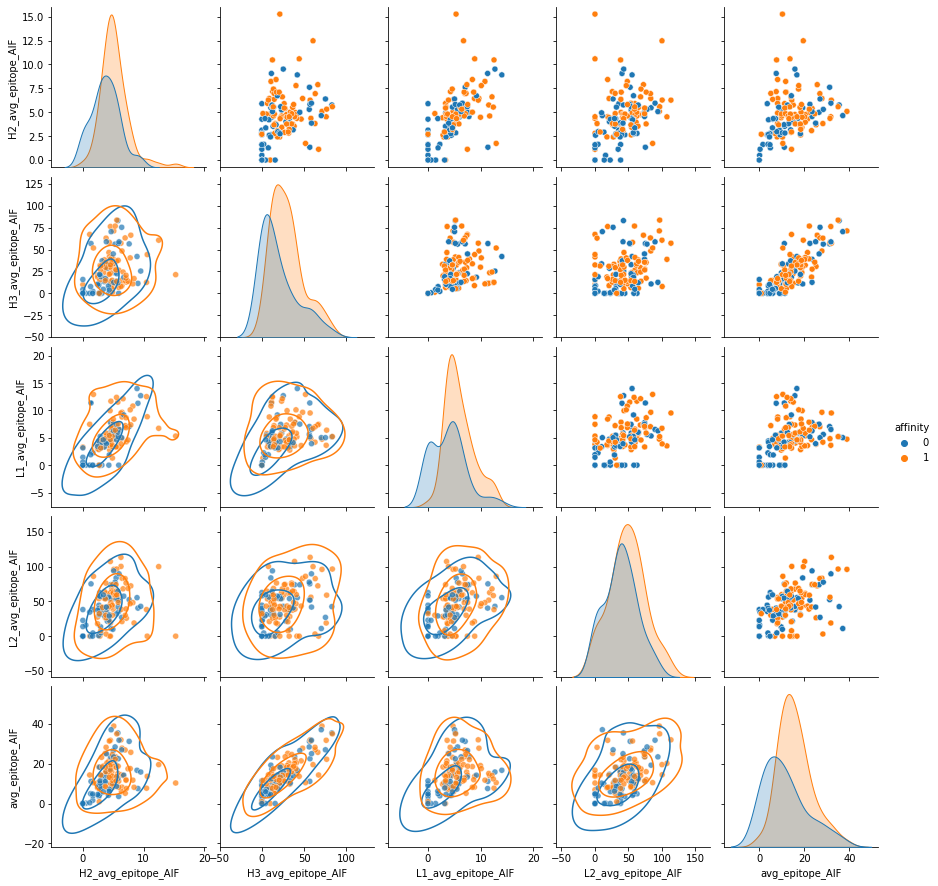

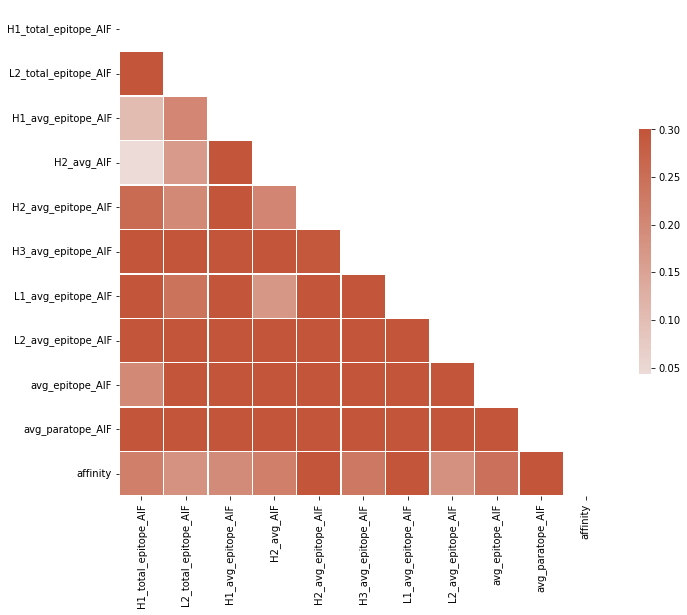

In [ ]:
#@title Plot correlations for top features within each feature set using the same settings as in previous cell

#@markdown Select number of features to use in each classifier and the number of the top features to then pairplot

features_map = [  ("aa_counts", feats_aa_counts),  ("aa_counts_CDR", feats_aa_counts_CDR),  ("energetics_pyrosetta", feats_pyrosetta),  ("Ab_info", feats_Ab_info), ("multivalent_interactions", feats_multivalent_epitope_sites),  ("dMaSIF_site", feats_dMaSIF_site),  ("SIN", feats_SIN_CDR),  ("AIF", feats_AIF_CDR),]

for i in range(8):
  used_feat = ''
  all_features = []
  Xs = []
  feats_to_use = []
  for feature_name, feats in features_map:
    X = np.vstack(feats)
    Xs.append(X)
    if i == features_map.index((feature_name, feats)):
      feats_to_use.append(list(range(sum([X.shape[1] for X in Xs[:-1]]), sum([X.shape[1] for X in Xs]))))
      used_feat += f"{feature_name}, "
      tmp_num = features_map.index((feature_name, feats))
      if tmp_num > 3: #ignore truss
        tmp_num += 1
      all_features.append(all_cols[tmp_num])
  
  X = np.concatenate(Xs, axis=1)
  y = np.array(y_final)
  pdb_list = np.array(track_pdb_ids)

  use_feature_selector = True 
  use_feature_selector_across_sets = False
  num_features = 10 #@param {type:"number"}
  num_top_feat_to_plot = 5 #@param {type:"number"}

  all_features = sum(all_features, []) #flatten
  feats_to_use = [item for items in feats_to_use for item in items]
  X = X[:,feats_to_use] # keep specified features
  X = np.nan_to_num(X)

  if remove_Nb:
    y = y[~np.isnan(X_Ab_info[:,2])] # feature #3 is L3 length
    X = X[~np.isnan(X_Ab_info[:,2]),:] # eliminates VHH which have nan values for some features (divide by LC epitope size)
    pdb_list = pdb_list[~np.isnan(X_Ab_info[:,2])]
    used_set = ' Abs'
  else:
    X = np.nan_to_num(X)
    used_set = ' Abs and Nbs'

  print('Classifiying ' + str(X.shape[0]) + used_set + ' from a potential set of ' + str(X.shape[1]) + ' features, derived from the following feature-sets:')
  print(used_feat[:-2])
  if use_feature_selector and not use_feature_selector_across_sets:
    print('Selecting ' + str(num_features) + ' features via: ' + str(selector_metric)[10:-19])
  if use_feature_selector_across_sets:
    print('Selecting ' + str(num_features_across_sets) + ' features from each of the 9 feature-sets via: ' + str(selector_metric)[10:-19])
  if report_failed_Abs:
    failed_pdbs = []
    used_pdb_list = []
    for i in df.index: 
      if df.loc[i,'pdb_id'] not in list(df_pyrosetta_relaxed.index):
          continue 
      else: 
        if (df['l3_length'].loc[i] > 0) and remove_Nb:
          used_pdb_list.append(df.loc[i,'pdb_id'])

  used_pdb_list = pdb_list 
  X_df = X
  if classifier_type == 'MLP':
    X_df =  StandardScaler().fit_transform(X_df)
  yreg = y

  ix_MDO = np.where(np.logical_or(yreg<=7.5,yreg>=9.5))[0]
  ix_middle = np.where(np.logical_and(yreg>7.5,yreg<9.5))[0]
  ix_unique = np.array([i for i, val in enumerate(used_pdb_list) if val not in duplicate_to_del])
  y_df = (yreg>affinity_cutoff).astype(int)

  from sklearn.model_selection import KFold
  from sklearn.metrics import roc_auc_score, f1_score
  from scipy.stats import spearmanr
  all_AUCs = []
  all_scores = []
  all_spearmans = []
  dfs_ = []
  stored_plots = {} # for figure creation
  warnings.filterwarnings("ignore")

  for n in range(n_fold):
    
    kf, classifier_mapping, clf = build_classifier(classifier_type, n_splits, n)
    
    # individual cross-validation 
    i = 0
    for ix_train, ix_test in kf.split(X_df):

        # dataset refinement based on user settings
        train_pdbs, test_pdbs, X_train, y_train, y_train_raw, X_test, y_test, ix_train, ix_test = refine_dataset(MDO_set, Middle_set, remove_homologous_Abs, ix_train, ix_test, ix_MDO, ix_middle, ix_unique, pdb_list, X_df, y_df, yreg)

        # feature selector pulling from all sets
        if use_feature_selector and (X.shape[1] > num_features):
          X_train, X_test, all_features_selected = feature_selector_all(X_train, y_train, X_test, all_features, selector_metric, num_features)
        elif use_feature_selector:
          all_features_selected = all_features

        # feature selector pulling from each set
        if use_feature_selector_across_sets:
          X_train, X_test, all_features_selected = feature_selector_sets(selector_metric, num_features_across_sets, X_aa_counts, X_Ab_info, X_pyrosetta, X_aa_counts_CDR, X_multivalent, X_dMaSIF_site, X_SIN, X_AIF, ix_train, y_train, ix_test, all_features)
            
        # train classifier 
        clf.fit(X_train, y_train)

        # get performance and AUC plots
        all_spearmans+=[spearmanr(clf.predict_proba(X_test)[:,1],y[ix_test])[0]]
        all_scores += [f1_score(y_test, clf.predict(X_test))] 
        if n == 0 and i == 0:
          svc_disp = None  
        all_AUCs, svc_disp = plot_roc_curve(clf, X_test, y_test, n, i, svc_disp, all_AUCs)
        i +=1 

        # store top features
        feature_importances = store_top_features(report_important_features, clf, all_features, all_features_selected, use_feature_selector, use_feature_selector_across_sets)
        dfs_ += [feature_importances]

        # store failed Abs 
        failed_pdbs.append(store_failed_Abs(report_failed_Abs, clf, X_test, y_test, ix_test, used_pdb_list))

  svc_disp.ax_.get_legend().remove()
  fract_tmp = int(100 / n_splits)
  plt.title(classifier_type + ' Classifier with ' + str(n_fold) + '-fold, ' + str(100-fract_tmp) + '/' + str(fract_tmp) + ' cross-validation:' + 
            ' \n' + 'median AUC: '+str(round(np.median(all_AUCs),2)) + ', median F1 score: '+str(round(np.median(all_scores),2)))

  save_output_results = True # manual setting, will overrite existing files. Swap to new results folder to use
  if save_output_results:
    if use_feature_selector: 
      tmp_path = '/content/protein_interactions/Antibody_DB/logs/Results/nm_{}_{}_{}_{}_v0'.format(num_features, used_feat[:-2].replace("_", "").replace(", ", "_"),n_fold,n_splits)
    else:
      tmp_path = '/content/protein_interactions/Antibody_DB/logs/Results/nm_{}_{}_{}_v0'.format(used_feat[:-2].replace("_", "").replace(", ", "_"),n_fold,n_splits)
    plt.savefig(tmp_path + '.png', dpi=300, bbox_inches = "tight")
  plt.show()

  print(classifier_type + ' Classifier with ' + str(n_fold) + '-fold, ' + str(100-fract_tmp) + '/' + str(fract_tmp) + ' cross-validation:')
  print('median F1 score: '+str(round(np.median(all_scores),2)))
  print('median AUC: '+str(round(np.median(all_AUCs),2)))
  
  if report_important_features:
    df_feat_summary = pd.concat(dfs_).groupby('feature',level=0).mean()
    df_feat_summary['feature'] = feature_importances['feature']
    df_feat_summary = df_feat_summary.sort_values('importance',ascending=False)
    df_feat_summary['importance'] = np.round(df_feat_summary['importance'],3)
    print('')
    print('-----')
    print('Most important features on average across the ' + str(n_fold*n_splits) + ' trees') 
    print('-----')
    print('Importance:           Feature:')
    print('')
    print(df_feat_summary.head(20).to_string(index=False, header=False))

  # report failed Abs
  if report_failed_Abs:
    failed_pdbs  = sum(failed_pdbs, []) # flatten
    failed_pdbs = dict(collections.Counter(failed_pdbs)) # get frequency
    sorted_failed = {k: v for k, v in sorted(failed_pdbs.items(), reverse=True, key=lambda item: item[1])} # sort on frequency
    print('')
    print('-----')
    print('PDBs for most commonly failed Antibodies with this classification scheme: ') 
    print('-----')
    print('PDB:   Fail Rate:   Affinity:')
    print('')
    i = 0
    for k in sorted_failed:
      if i < 10:
        print(k + '        ' + str( 100*(sorted_failed[k] / (n_fold)) ) + '%     ' + str(round(-np.log10(df['affinity'].loc[df['pdb_id']==k]),2).values[0])  ) 
      i+=1

  # Save to drive
  if save_output_results and report_important_features and report_failed_Abs:
    df_feat_summary.to_csv(tmp_path + '.csv')
    (pd.DataFrame.from_dict(sorted_failed, orient='index')).to_csv(tmp_path + '_failed_Abs.csv')

  
  # Feature plotting 
  if report_important_features and (classifier_type != 'MLP'):
    # plot pairplots
    X_labeled = pd.DataFrame(X_df, columns=all_features)
    X_labeled = X_labeled[X_labeled.columns.drop(list(X_labeled.filter(regex='None')))] #catch for missing cononical CDR labels
    X_labeled_selected = X_labeled[X_labeled.columns.intersection(list(df_feat_summary.head(num_top_feat_to_plot)['feature']))] #all_features_selected
    X_labeled_selected['affinity'] = y_df
    X_labeled_selected = X_labeled_selected.loc[list(ix_train)+list(ix_test)]

    g = sns.pairplot(X_labeled_selected, plot_kws=dict(alpha=0.7), hue='affinity', diag_kind="kde")
    g.map_lower(sns.kdeplot, levels=3, bw_adjust=1.5)
    g.map_upper(sns.scatterplot)
    if save_output_results:
      tmp_path = '/content/protein_interactions/Antibody_DB/logs/Results/pairplot_{}_{}_{}_{}_v0'.format(num_features, used_feat[:-2].replace("_", "").replace(", ", "_"),n_fold,n_splits)
      plt.savefig(tmp_path + '.png', dpi=300, bbox_inches = "tight")

    # plot corrs
    X_labeled_selected_corr = X_labeled[X_labeled.columns.intersection(list(df_feat_summary['feature']))] #all_features_selected
    X_labeled_selected_corr['affinity'] = y_df
    X_labeled_selected_corr = X_labeled_selected_corr.loc[list(ix_train)+list(ix_test)]
    corr = X_labeled_selected_corr.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
  if save_output_results:
    tmp_path = '/content/protein_interactions/Antibody_DB/logs/Results/corrplot_{}_{}_{}_{}_v0'.format(num_features, used_feat[:-2].replace("_", "").replace(", ", "_"),n_fold,n_splits)
    plt.savefig(tmp_path + '.png', dpi=300, bbox_inches = "tight")


In [ ]:
#@title Download Results
!zip -r /content/protein_interactions/Antibody_DB/logs/Results.zip /content/protein_interactions/Antibody_DB/logs/Results
from google.colab import files
files.download("/content/protein_interactions/Antibody_DB/logs/Results.zip")

  adding: content/protein_interactions/Antibody_DB/logs/Results/ (stored 0%)
  adding: content/protein_interactions/Antibody_DB/logs/Results/nm_10_multivalentinteractions_50_10_v0_failed_Abs.csv (deflated 46%)
  adding: content/protein_interactions/Antibody_DB/logs/Results/pairplot_10_SIN_50_10_v0.png (deflated 3%)
  adding: content/protein_interactions/Antibody_DB/logs/Results/nm_10_AIF_50_10_v0.csv (deflated 55%)
  adding: content/protein_interactions/Antibody_DB/logs/Results/nm_300_aacounts_energetics_Abinfo_aacountsCDR_multivalentinteractions_dMaSIFsite_SIN_AIF_50_10_v0.png (deflated 6%)
  adding: content/protein_interactions/Antibody_DB/logs/Results/nm_10_multivalentinteractions_50_10_v0.csv (deflated 46%)
  adding: content/protein_interactions/Antibody_DB/logs/Results/nm_300_aacounts_energetics_Abinfo_aacountsCDR_multivalentinteractions_dMaSIFsite_SIN_AIF_50_10_v0_failed_Abs.csv (deflated 44%)
  adding: content/protein_interactions/Antibody_DB/logs/Results/nm_energetics_aacountsC

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>